In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess

pd.set_option("display.max_columns",30)

# Functions

In [2]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_aggregation(var_name):
    """
    Define custom aggregation functions for different variables during resampling.
    """
    def aggregate(series):
        # Exclude if the series has too many missing values
        if series.isna().sum() > 20:
            return np.nan
        # Exclude if the series has fewer than 3 unique values (except for 'tipping')
        if var_name != 'tipping' and series.nunique() <= 3:
            return np.nan

        if var_name == 'tipping':
            # Sum for precipitation
            return series.sum()
        elif var_name == 'wind_speed':
            # Mean for wind speed
            return series.mean()
        elif var_name == 'wind_dir':
            # Circular mean for wind direction
            return circular_mean(series)
        else:
            # Median for other variables
            return series.median()
    return aggregate

def apply_aggregation(df):
    """
    Resample the DataFrame to hourly intervals and apply custom aggregation.
    """
    df = df.replace(-999.99, np.nan)

    # Replace 0.0 values with NaN and apply range filter for 'mcp9808' column
    if 'mcp9808' in df.columns:
        df['mcp9808'] = df['mcp9808'].replace(0.0, np.nan)
        df['mcp9808'] = df['mcp9808'].apply(lambda x: x if -45 <= x <= 45 else np.nan)

    # Dictionary to store custom aggregations for each variable
    aggregation_dict = {var: custom_aggregation(var) for var in df.columns}

    # Resample DataFrame to hourly intervals and apply custom aggregation for each variable
    hourly_df = df.resample('h').apply(lambda x: pd.Series({var: func(x[var]) for var, func in aggregation_dict.items()}))

    return hourly_df


In [3]:
def plot_event_comparison(event_time, 
                          hourly_df, 
                          minutely_df, 
                          variable_hourly, 
                          variable_minute, 
                          era5_variable, 
                          lat, 
                          lon, 
                          time_window=pd.Timedelta(hours=6),
                          era5_ds=None, 
                          same_y_axis=False,
                          title_suffix="",
                          save_fig=False,
                          save_path=None):
    """
    Plots a comparison between hourly and minutely measurements alongside ERA5 data for a specified event.

    Parameters:
    -----------
    event_time : pd.Timestamp
        The timestamp of the event to analyze.

    hourly_df : pd.DataFrame
        DataFrame containing hourly measurements with a DateTime index.

    minutely_df : pd.DataFrame
        DataFrame containing minutely measurements with a DateTime index.

    era5_ds : xarray.Dataset
        Xarray Dataset containing ERA5 data.

    variable_hourly : str
        Column name in `hourly_df` for the hourly measurement (e.g., "mcp9808", "tipping").

    variable_minute : str
        Column name in `minutely_df` for the minutely measurement (e.g., "mcp9808", "tipping").

    era5_variable : str
        Variable name in `era5_ds` for ERA5 data (e.g., "t2m", "tp").

    lat : float
        Latitude for ERA5 data extraction.

    lon : float
        Longitude for ERA5 data extraction.

    time_window : pd.Timedelta, optional
        Duration before and after the event to include in the analysis. Default is 6 hours.

    same_y_axis : bool, optional
        If True, plots all measurements on the same y-axis. If False, uses separate y-axes. Default is False.

    title_suffix : str, optional
        Additional string to append to the plot title. Useful for distinguishing between events. Default is "".

    save_fig : bool, optional
        If True, saves the figure to `save_path`. Default is False.

    save_path : str, optional
        File path to save the figure. Required if `save_fig` is True.

    Returns:
    --------
    None
    """
    # Define the time window
    start_time = event_time - time_window
    end_time = event_time + time_window

    # Filter the DataFrames within the time window
    filtered_hourly = hourly_df.loc[start_time:end_time]
    filtered_minutely = minutely_df.loc[start_time:end_time]
    if era5_ds:
        # Extract ERA5 data for the specified location and time window
        era5_data = era5_ds[era5_variable].sel(lat=lat, lon=lon, method='nearest')
        era5_filtered = era5_data.sel(time=slice(start_time, end_time))
        era5_pd = era5_filtered.to_pandas()

    # Ensure that the indices align for plotting
    # If not, consider resampling or interpolating
    # For simplicity, we'll assume they are aligned or handle missing data gracefully

    # Start plotting
    plt.figure(figsize=(16, 8))

    if variable_hourly == "tipping": 
        unit = "mm"
    elif variable_hourly == "wind_speed":
        unit = "m/s"
    else:
        unit = "°C"

    if same_y_axis:
        # Plot all data on the same y-axis
        plt.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        plt.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=2, marker='o', alpha=0.5, markersize=2)
        if era5_ds:
            plt.plot(era5_pd.index, era5_pd.values, 
                    color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')

        plt.xlabel("Datetime", fontsize=12)
        plt.ylabel(f"{variable_hourly.capitalize()} in {unit}", fontsize=12)
        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)
        plt.grid(alpha=0.7)
        plt.legend(loc="upper right", fontsize=12)
    else:
        # Create primary y-axis
        ax1 = plt.gca()
        ax1.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        ax1.set_xlabel("Datetime", fontsize=12)
        ax1.set_ylabel(f"{variable_hourly.capitalize()} in {unit} (Hourly)", fontsize=12)
        ax1.tick_params(axis='y')
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Plot minutely data on the same primary y-axis
        ax1.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=2, marker='o', alpha=0.5, markersize=2)
        if era5_ds:
            # Create secondary y-axis for ERA5 data
            ax2 = ax1.twinx()
            ax2.plot(era5_pd.index, era5_pd.values, 
                    color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')
            ax2.set_ylabel(f"ERA5 {era5_variable.upper()} in {unit}", fontsize=12)
            ax2.tick_params(axis='y')

            # Combine legends from both axes
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)

    # Improve x-axis date formatting
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Optionally save the figure
    if save_fig:
        if save_path is None:
            raise ValueError("save_path must be provided if save_fig is True.")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    # Display the plot
    plt.show()

In [4]:
def statistics(df, hourly = True): 
    # turn objec index into datetime index
    df.index = pd.to_datetime(df.index)

    df = df.sort_index()

    if hourly:
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')  # min stands for minute frequency
        time_unit  = "hour"
    else:
        # Create a complete minute-wise index
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')  # min stands for minute frequency
        time_unit  = "minute"
    
    # Reindex the dataframe to include all minutes, filling missing with NaN
    df = df.reindex(full_index) 

    # Total timespan/steps
    total_time = full_index.shape[0]

    # Actual measurements not Nan
    actual_measurements = df.notna().sum()
    relative_measurements = actual_measurements / total_time * 100

    # Non - zero measurments 
    zero_measurements = (df == 0).sum()
    nan_count = df.isna().sum()
    
    non_zero_measurements = actual_measurements - zero_measurements
    relative_non_zero_measurements = non_zero_measurements / total_time * 100
    nonzerorelativetoactual = non_zero_measurements / actual_measurements * 100
    
    print(f"Total {time_unit}s: {total_time}")
    print(f"Total {time_unit}s: 100%")
    print(f"Actual measurements: {actual_measurements}")
    print(f"Relative measurements: {relative_measurements:.2f}%")
    print(f"Non-zero measurements: {non_zero_measurements}")
    print(f"Relative non-zero measurements: {relative_non_zero_measurements:.2f}%")
    print(f"Non-zero relative to actual: {nonzerorelativetoactual:.2f}%")
    print(f"Zero measurements: {zero_measurements}")
    print(f"NaN measurements: {nan_count}")

In [5]:
def plot_hist(df, var_name, station, save=False, log=False):

    if var_name == 'tipping': 
        var_name_plot = 'precipitation'
    elif var_name == 'mcp9808':
        var_name_plot = 'temperature'
    elif var_name == 'htu_hum':
        var_name_plot = 'humidity'
    elif var_name == 'bmp280_pres':
        var_name_plot = 'pressure'
    else:
        var_name_plot = var_name

    staion_name = station
    # Create a histogram with log scale on the y-axis
    
    plt.figure(figsize=(14,6) )
    plt.hist(df[var_name], bins=50, log=log, color='mediumblue', edgecolor='black')     

    # Add labels and title
    plt.xlabel(f"{var_name_plot.capitalize()} Bins")
    plt.ylabel("Count")
    plt.title(f"{station.capitalize()}: Histogram of {var_name_plot.capitalize()}")
    plt.grid(True)

    if save:
    # Check if the 'eda' directory exists, if not, create it
        save_dir = "eda"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        plt.savefig(f"eda/{staion_name}_{var_name}_hist.png")
        print(f"Figure saved as eda/{staion_name}_{var_name}_hist.png")

    # Display the plot
    plt.show()


In [6]:
def plot_variable_over_time(df, var_name, year=None, title_add_on = None):
    """
    Plots a specified variable over time from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data with a datetime index.
    variable (str): The name of the column to plot.
    year (int, optional): The specific year to plot. If None, plots all available data.
    """
    # Check if the variable exists in the DataFrame
    if var_name not in df.columns:
        raise ValueError(f"Variable '{var_name}' not found in DataFrame columns.")
    
    if var_name == 'tipping': 
        var_name_plot = 'precipitation'
        unit = "mm"
    elif var_name == 'mcp9808':
        var_name_plot = 'temperature'
        unit = "°C"
    elif var_name == 'htu_hum':
        var_name_plot = 'humidity'
        unit = "%"
    elif var_name == 'bmp280_pres':
        var_name_plot = 'pressure'
        unit = "hPa"
    else:
        var_name_plot = var_name
        unit = ""
    # Filter by year if specified
    if year is not None:
        df = df[df.index.year == year]
    
    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df[var_name], marker = "x", label=f"{var_name} over time", color='green')
    plt.title(f"{var_name_plot.capitalize()} {title_add_on} Over Time in {unit}" + (f" in {year}" if year else ""))
    plt.xlabel("Date")
    plt.xticks(rotation=45)  # Rotate x-axis values

    plt.ylabel(f"{var_name_plot.capitalize()} in {unit}")
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()

# Example usage:
# df should be a DataFrame with a datetime index and a column named 'temperature' (or any chosen variable).
# plot_variable_over_time(df, 'temperature', year=2023)


# Analysis

## Overview

In [7]:
marshall_processed_df = pd.read_csv("station_data_processed/marshall_hourly_processed_data.csv", index_col=0)
marshall_processed_df.index = pd.to_datetime(marshall_processed_df.index, errors='coerce')

# Apply the  aggregation
marshall_hourly_df = apply_aggregation(marshall_processed_df)

In [2]:
marshall_hourly_df = pd.read_csv("station_data_processed/marshall_hourly_aggregated_data.csv", index_col=0,  parse_dates=True)


In [8]:
marshall_hourly_df.dropna(how='all', axis=1, inplace=True) 
marshall_hourly_df.to_csv("station_data_processed/marshall_hourly_aggregated_data.csv", index=True)
print(marshall_hourly_df.index)
print(marshall_hourly_df.index.dtype)

DatetimeIndex(['2017-03-01 05:00:00', '2017-03-01 06:00:00',
               '2017-03-01 07:00:00', '2017-03-01 08:00:00',
               '2017-03-01 09:00:00', '2017-03-01 10:00:00',
               '2017-03-01 11:00:00', '2017-03-01 12:00:00',
               '2017-03-01 13:00:00', '2017-03-01 14:00:00',
               ...
               '2023-11-29 10:00:00', '2023-11-29 11:00:00',
               '2023-11-29 12:00:00', '2023-11-29 13:00:00',
               '2023-11-29 14:00:00', '2023-11-29 15:00:00',
               '2023-11-29 16:00:00', '2023-11-29 17:00:00',
               '2023-11-29 18:00:00', '2023-11-29 19:00:00'],
              dtype='datetime64[ns]', name='datetime', length=59151, freq='h')
datetime64[ns]


In [10]:
marshall_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59151 entries, 2017-03-01 05:00:00 to 2023-11-29 19:00:00
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bmp180_temp  38990 non-null  float64
 1   bmp180_pres  39811 non-null  float64
 2   bmp180_slp   39802 non-null  float64
 3   htu_temp     42839 non-null  float64
 4   htu_hum      39757 non-null  float64
 5   mcp9808      41883 non-null  float64
 6   tipping      46388 non-null  float64
 7   vis_light    13639 non-null  float64
 8   ir_light     13166 non-null  float64
 9   uv_light     7993 non-null   float64
 10  wind_dir     37483 non-null  float64
 11  wind_speed   36858 non-null  float64
dtypes: float64(12)
memory usage: 5.9 MB


In [11]:
marshall_hourly_df.describe()

bmp180_temp   bmp180_pres    bmp180_slp      htu_temp       htu_hum  \
count  38990.000000  39811.000000  39802.000000  42839.000000  39757.000000   
mean      11.335457    823.842275   1012.054002     11.755801     46.502289   
std       10.531849     11.784119     15.631268     10.459032     23.209777   
min      -29.300000    594.980000    739.595000    -28.900000      0.800000   
25%        3.700000    821.180000   1006.201250      4.100000     28.250000   
50%       11.900000    825.155000   1012.310000     12.300000     43.200000   
75%       19.400000    828.560000   1019.040000     19.700000     63.950000   
max       35.800000    839.450000   1053.360000     35.900000     99.800000   

            mcp9808       tipping     vis_light      ir_light     uv_light  \
count  41883.000000  46388.000000  13639.000000  13166.000000  7993.000000   
mean      11.097412      0.040756    400.614085   1804.249658   130.110472   
std       10.511896      2.300360    207.718534   2201.495972   119.556154   
min      -28.800000      0.000000      0.000000      0.000000     0.000000   
25%        3.400000      0.000000    260.000000    253.000000    27.000000   
50%       11.400000      0.000000    270.000000    439.750000    99.500000   
75%       19.100000      0.000000    486.000000   2836.500000   206.000000   
max       35.800000    468.000000   1314.000000  11537.000000   566.000000   

           wind_dir    wind_speed  
count  37483.000000  36858.000000  
mean     192.689326      1.754441  
std      107.605774      1.611132  
min        0.000869      0.001034  
25%       98.709788      0.622357  
50%      213.407268      1.370522  
75%      277.720832      2.382261  
max      359.998742     16.270877

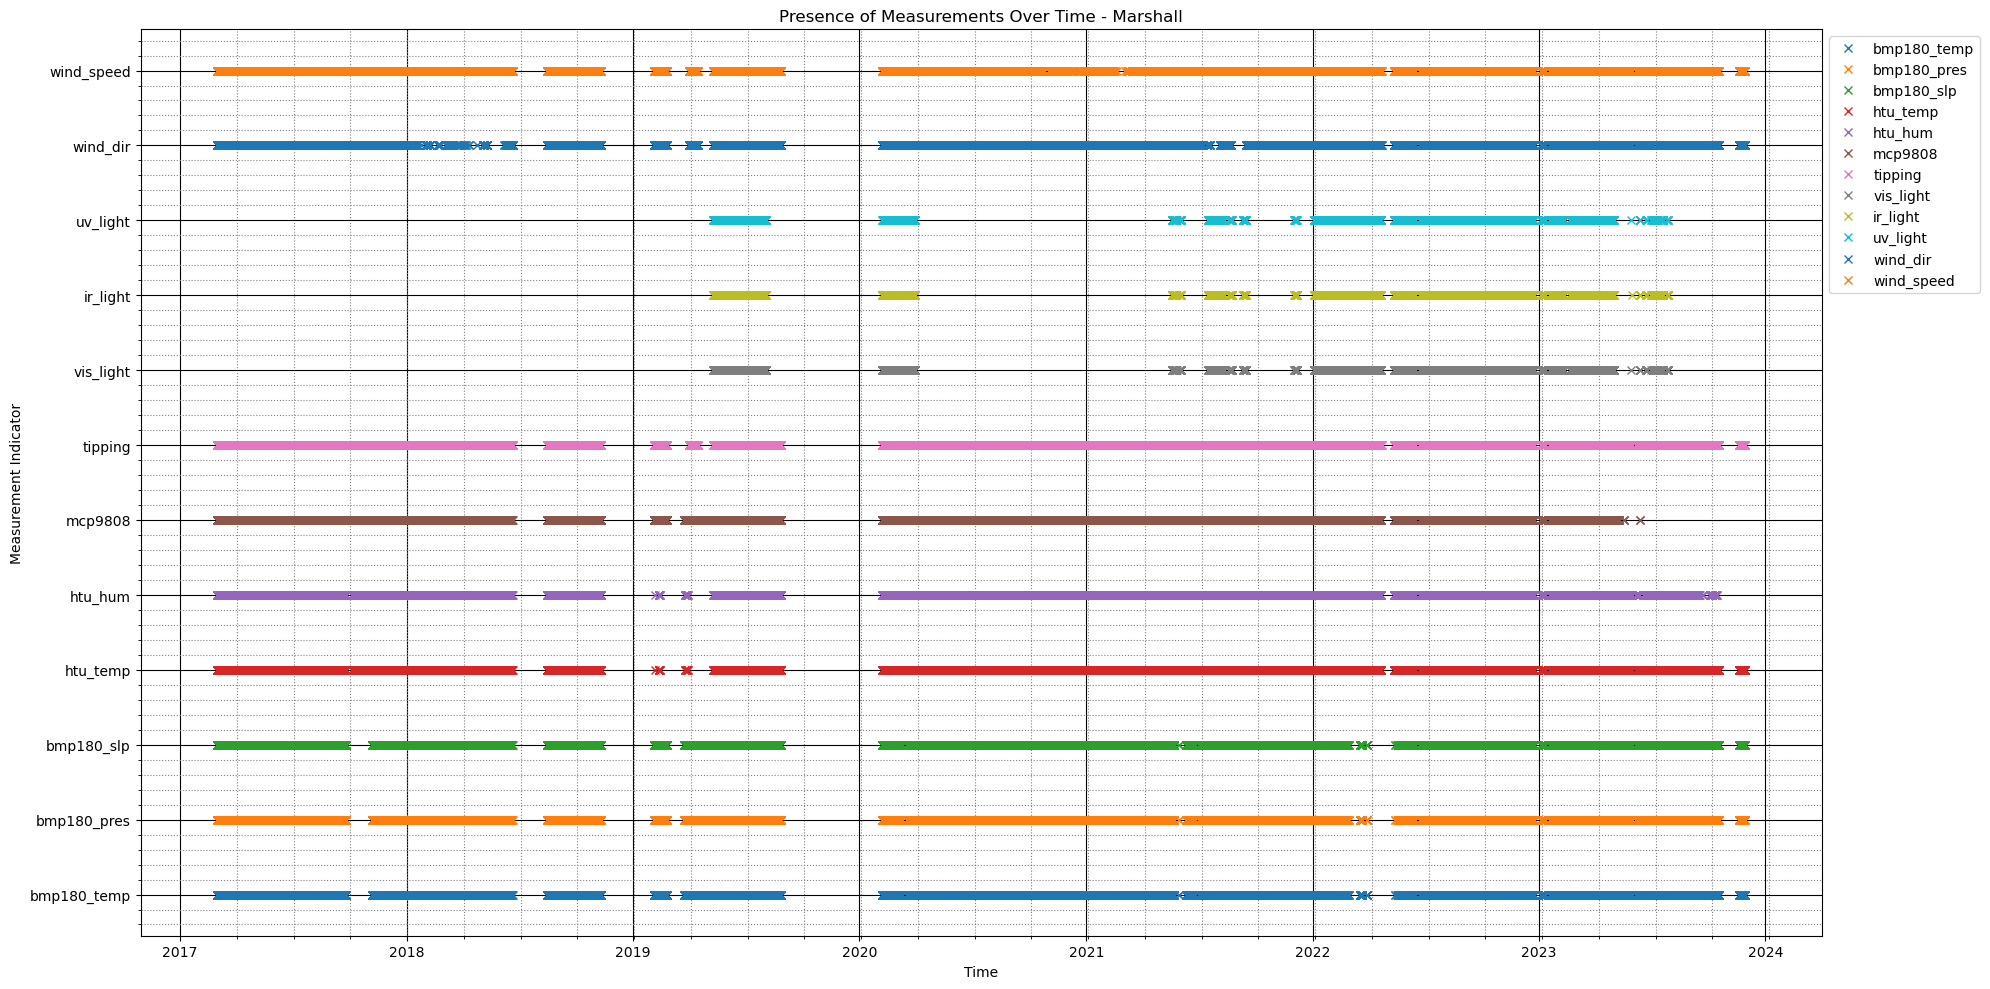

In [3]:
for i, column in enumerate(marshall_hourly_df.columns, start=1):
    marker_column = f"{column}_marker"
    # Assign 'i' where data is present, else NaN
    marshall_hourly_df[marker_column] = marshall_hourly_df[column].notna().map({True: i, False: np.nan})

# Initialize the plot
plt.figure(figsize=(20, 10))

# Plot each marker column with a unique vertical offset
for column in marshall_hourly_df.columns:
    if column.endswith('_marker'):
        plt.plot(
            marshall_hourly_df.index,
            marshall_hourly_df[column],
            marker='x',
            linestyle='',
            label=column.replace('_marker', '')
        )

# Customize the plot
plt.xlabel('Time')
# plt.xticks(rotation=45)
plt.ylabel('Measurement Indicator')
plt.title('Presence of Measurements Over Time - Marshall')
plt.yticks(range(1, len(marshall_hourly_df.columns)//2 + 1), marshall_hourly_df.columns[:len(marshall_hourly_df.columns)//2])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.minorticks_on()
# Configure Major Grid Lines
plt.grid(which='major', linestyle='-', color='black')
# Configure Minor Grid Lines
plt.grid(which='minor', linestyle=':', color='gray')
plt.tight_layout()
plt.show()

## Statistics

In [12]:
summary = statistics(marshall_hourly_df["mcp9808"])


Total hours: 59151
Total hours: 100%
Actual measurements: 41883
Relative measurements: 70.81%
Non-zero measurements: 41870
Relative non-zero measurements: 70.78%
Non-zero relative to actual: 99.97%
Zero measurements: 13
NaN measurements: 17268


In [13]:
summary = statistics(marshall_hourly_df["tipping"])


Total hours: 59151
Total hours: 100%
Actual measurements: 46388
Relative measurements: 78.42%
Non-zero measurements: 1140
Relative non-zero measurements: 1.93%
Non-zero relative to actual: 2.46%
Zero measurements: 45248
NaN measurements: 12763


In [14]:
summary = statistics(marshall_hourly_df["wind_speed"])


Total hours: 59151
Total hours: 100%
Actual measurements: 36858
Relative measurements: 62.31%
Non-zero measurements: 36858
Relative non-zero measurements: 62.31%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 22293


In [16]:
summary = statistics(marshall_hourly_df["bmp180_pres"])


Total hours: 59151
Total hours: 100%
Actual measurements: 39811
Relative measurements: 67.30%
Non-zero measurements: 39811
Relative non-zero measurements: 67.30%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 19340


In [17]:
summary = statistics(marshall_hourly_df["htu_hum"])


Total hours: 59151
Total hours: 100%
Actual measurements: 39757
Relative measurements: 67.21%
Non-zero measurements: 39757
Relative non-zero measurements: 67.21%
Non-zero relative to actual: 100.00%
Zero measurements: 0
NaN measurements: 19394


## Histogram

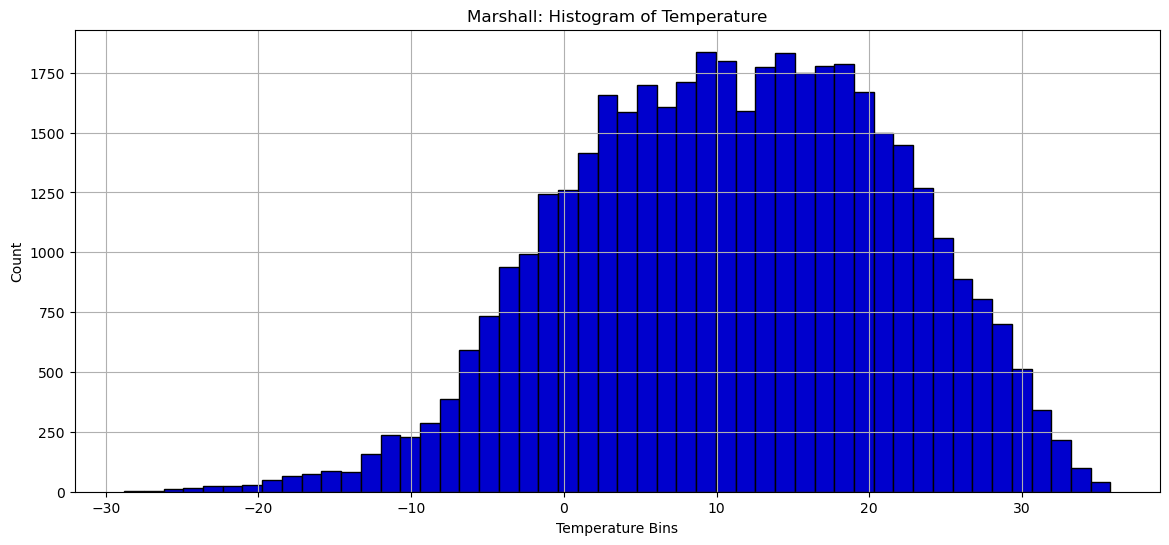

In [25]:
plot_hist(marshall_hourly_df, "mcp9808", "Marshall", save=False)

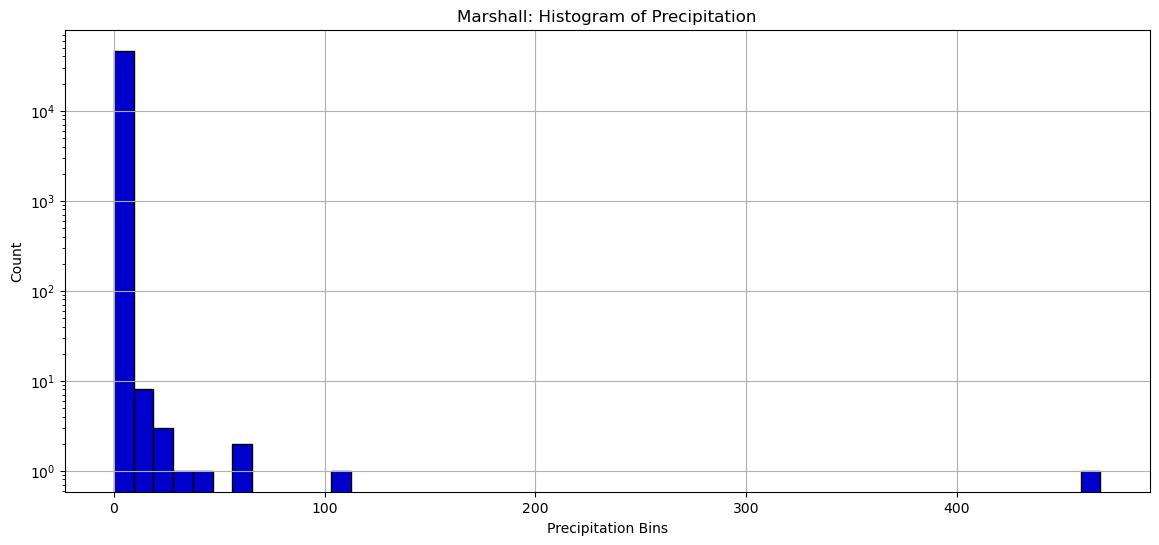

In [26]:
plot_hist(marshall_hourly_df, "tipping", "Marshall", save=False, log=True)

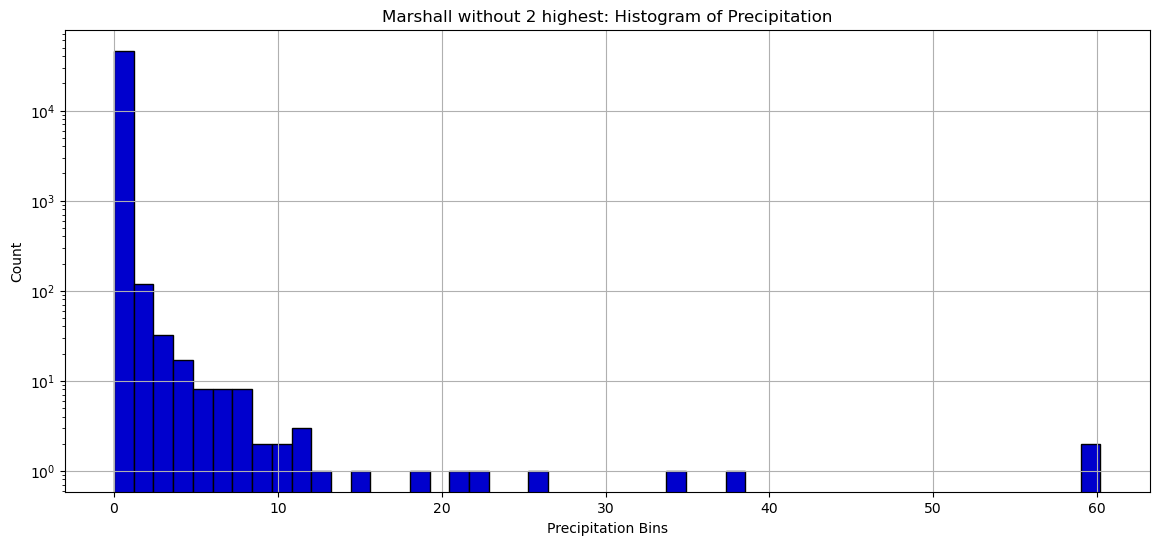

In [29]:
x = 0  # Number of rows to drop

# Sort by the column in descending order and drop the top x rows
df_dropped = marshall_hourly_df.sort_values(by="tipping", ascending=False).iloc[x:]

# Reset index if needed
df_dropped = df_dropped.reset_index(drop=True)

plot_hist(df_dropped, "tipping", "Marshall without 2 highest", save=False, log=True)

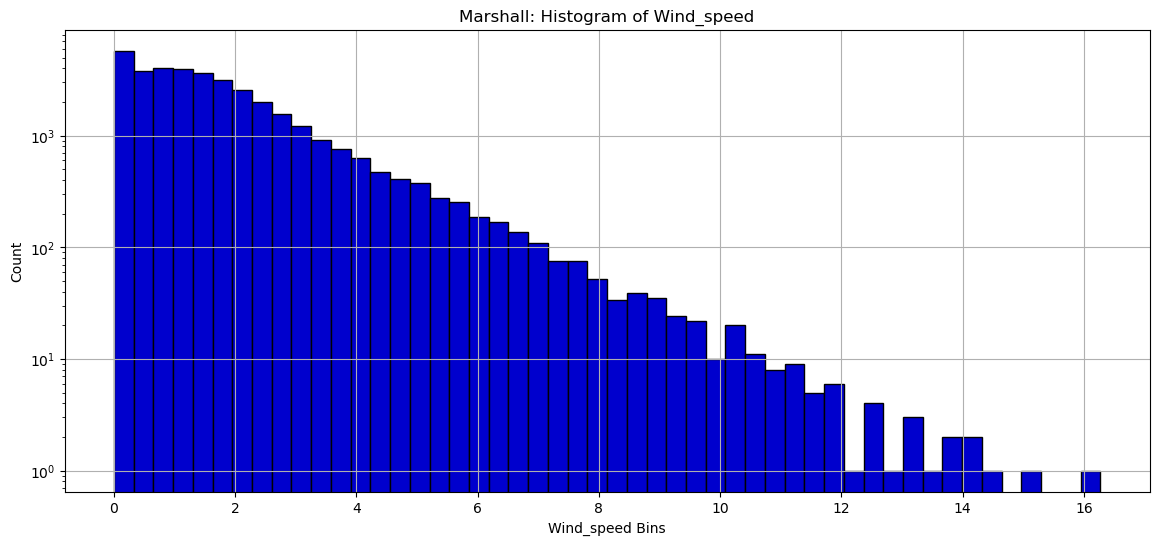

In [30]:
plot_hist(marshall_hourly_df, "wind_speed", "Marshall", save=False, log=True)

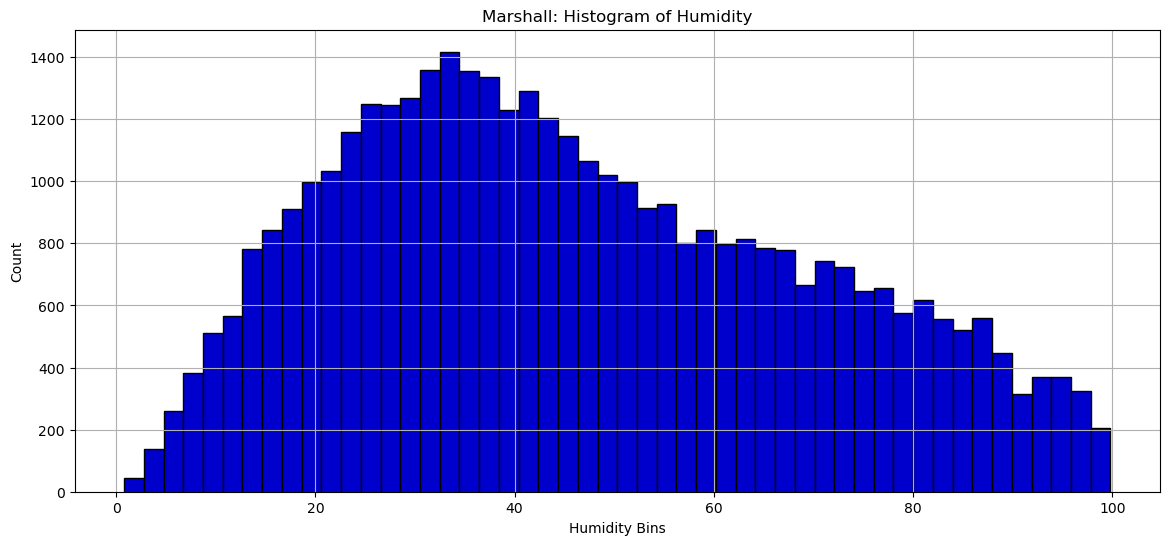

In [31]:
plot_hist(marshall_hourly_df, "htu_hum", "Marshall", save=False, log=False)

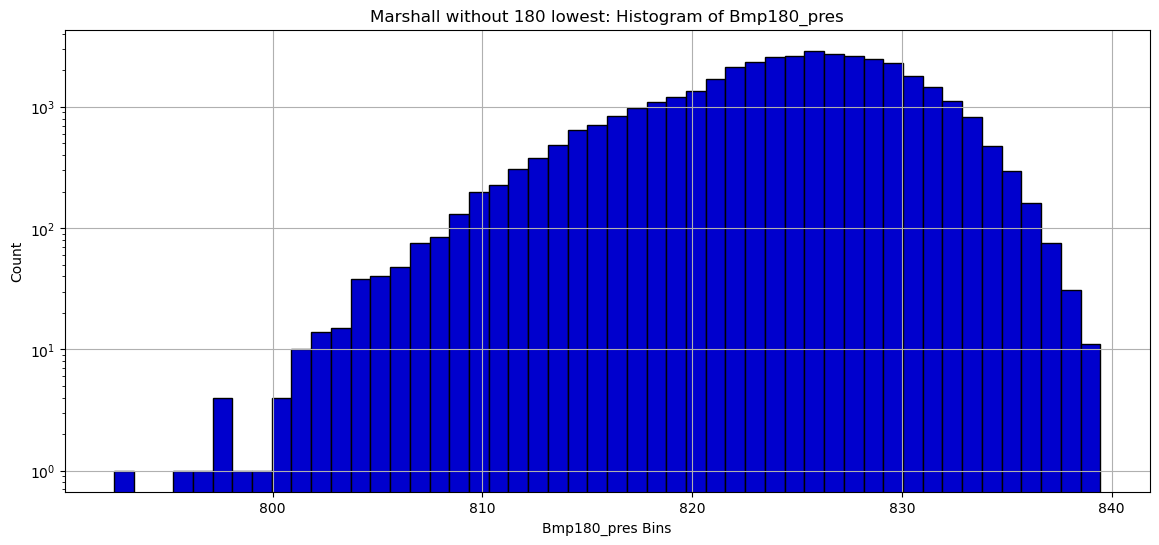

In [42]:
x = 180 # Number of rows to drop below lowest measurments

# Sort by the column in descending order and drop the top x rows
df_dropped = marshall_hourly_df.sort_values(by="bmp180_pres", ascending=True).iloc[x:]

# Reset index if needed
df_dropped = df_dropped.reset_index(drop=True)

plot_hist(df_dropped, "bmp180_pres", "Marshall without 180 lowest", save=False, log=True)


## Overview Plots

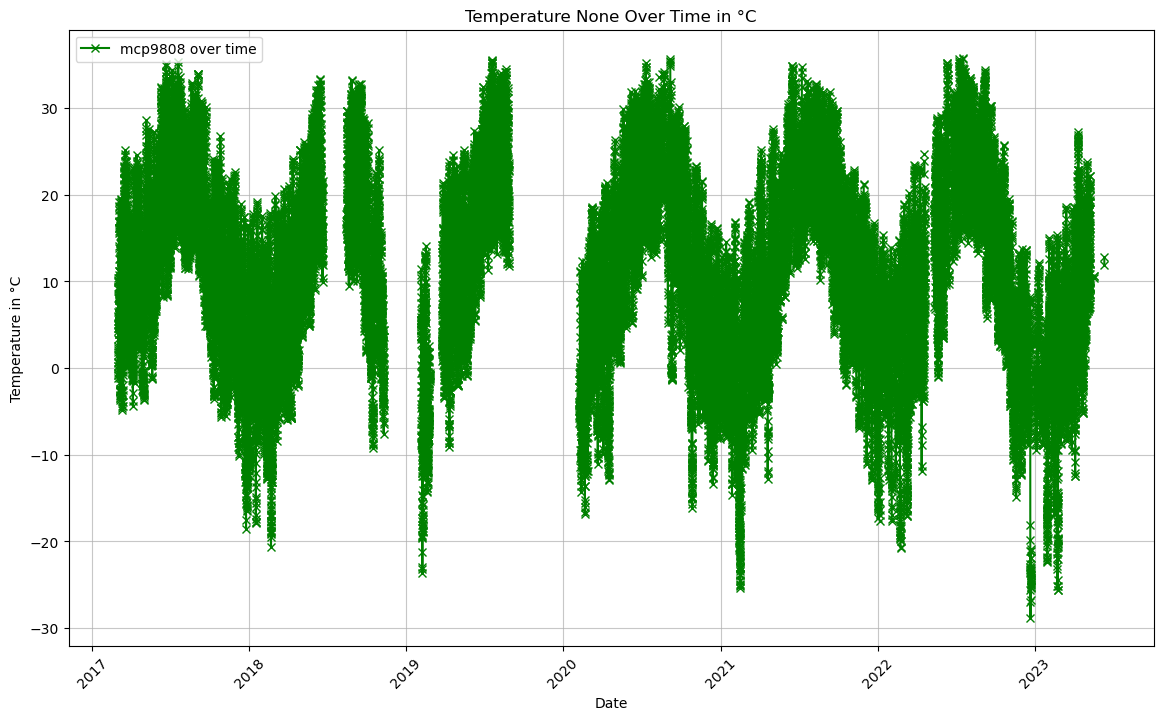

In [43]:
plot_variable_over_time(marshall_hourly_df, "mcp9808", year=None)


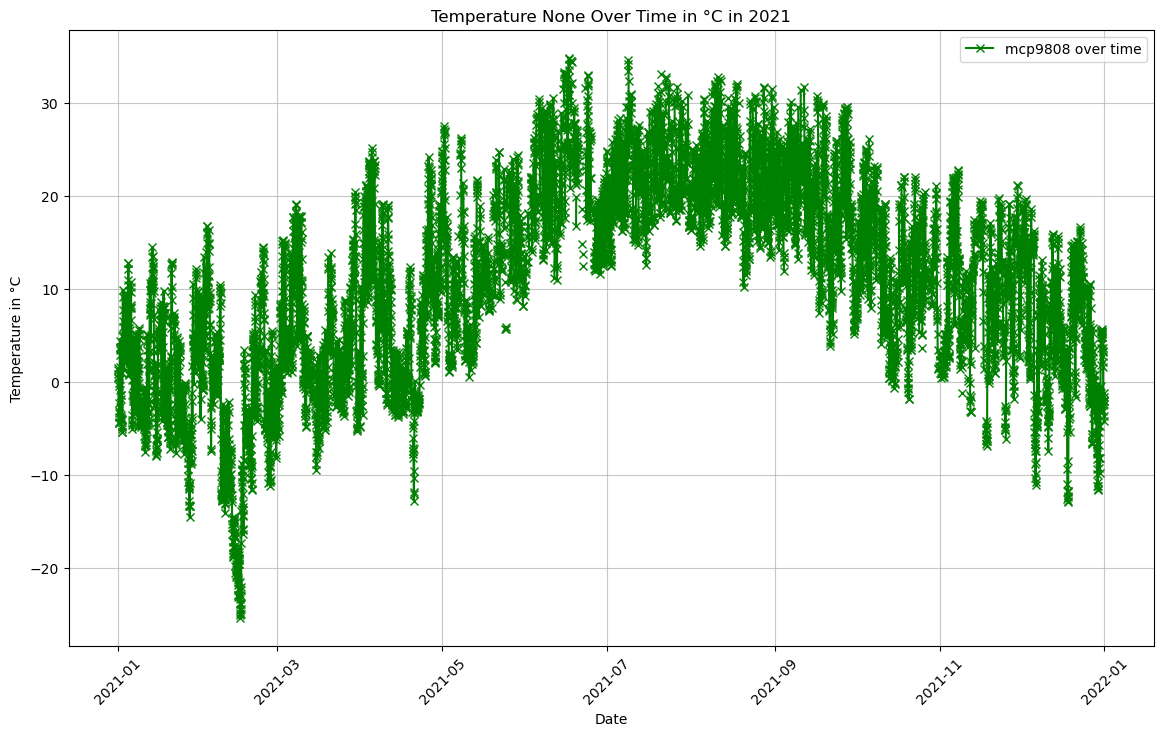

In [44]:
plot_variable_over_time(marshall_hourly_df, "mcp9808", year=2021)


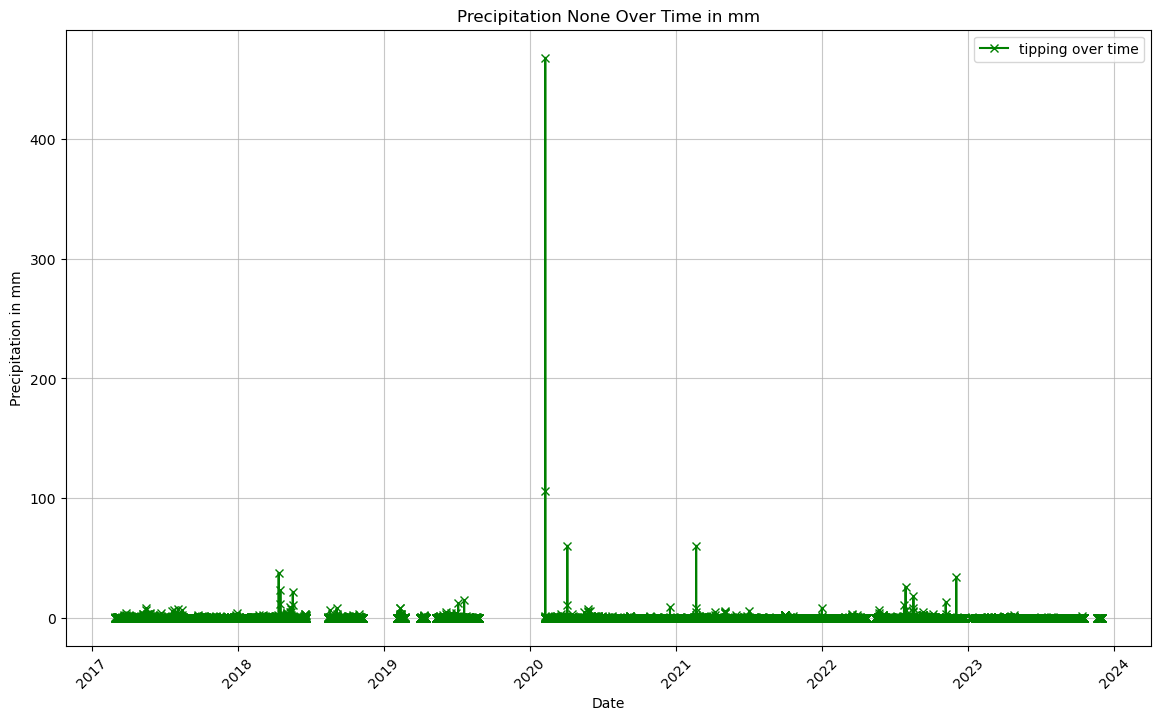

In [45]:
plot_variable_over_time(marshall_hourly_df, "tipping", year=None)


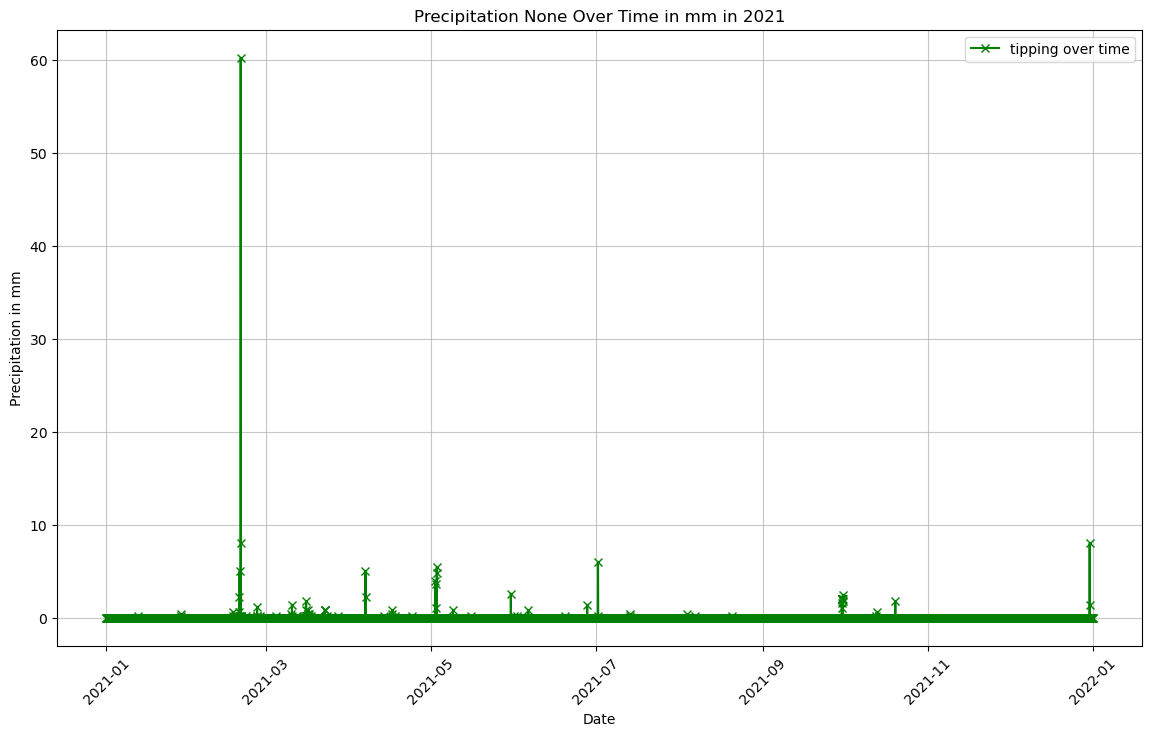

In [46]:
plot_variable_over_time(marshall_hourly_df, "tipping", year=2021)


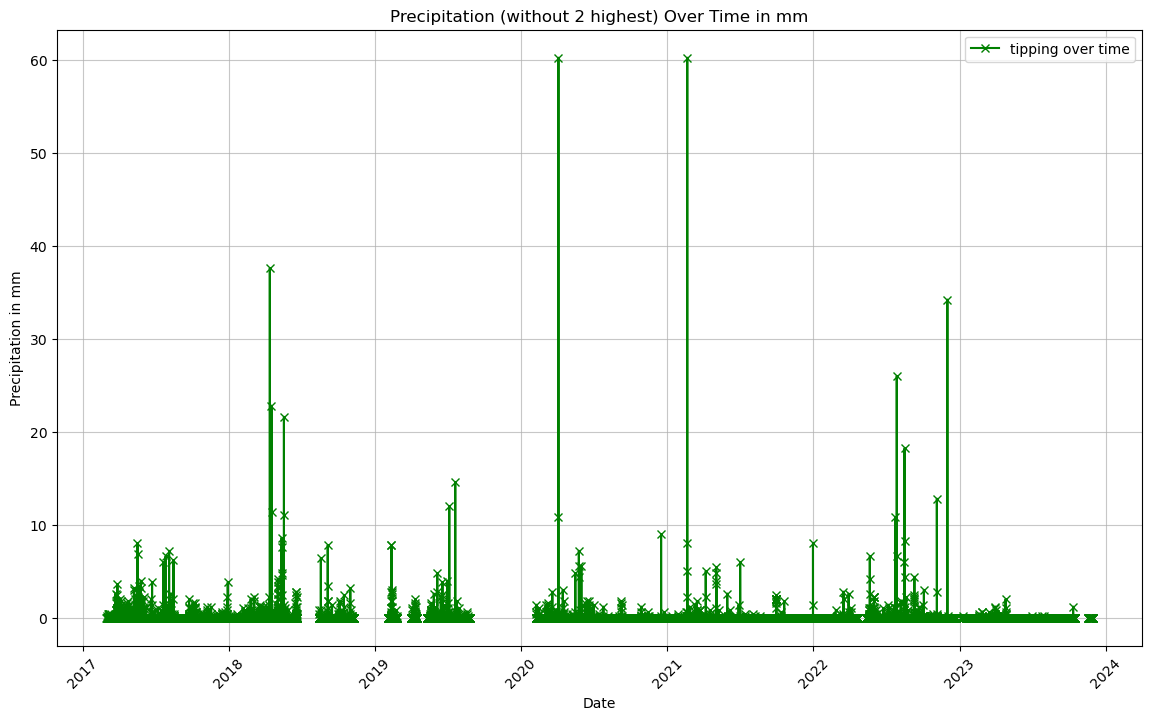

In [50]:
x = 2  # Number of rows to drop

# Sort by the column in descending order and drop the top x rows
top_values = marshall_hourly_df["tipping"].nlargest(x).values
df_filtered = marshall_hourly_df[~marshall_hourly_df["tipping"].isin(top_values)]

plot_variable_over_time(df_filtered, "tipping", year=None, title_add_on="(without 2 highest)")


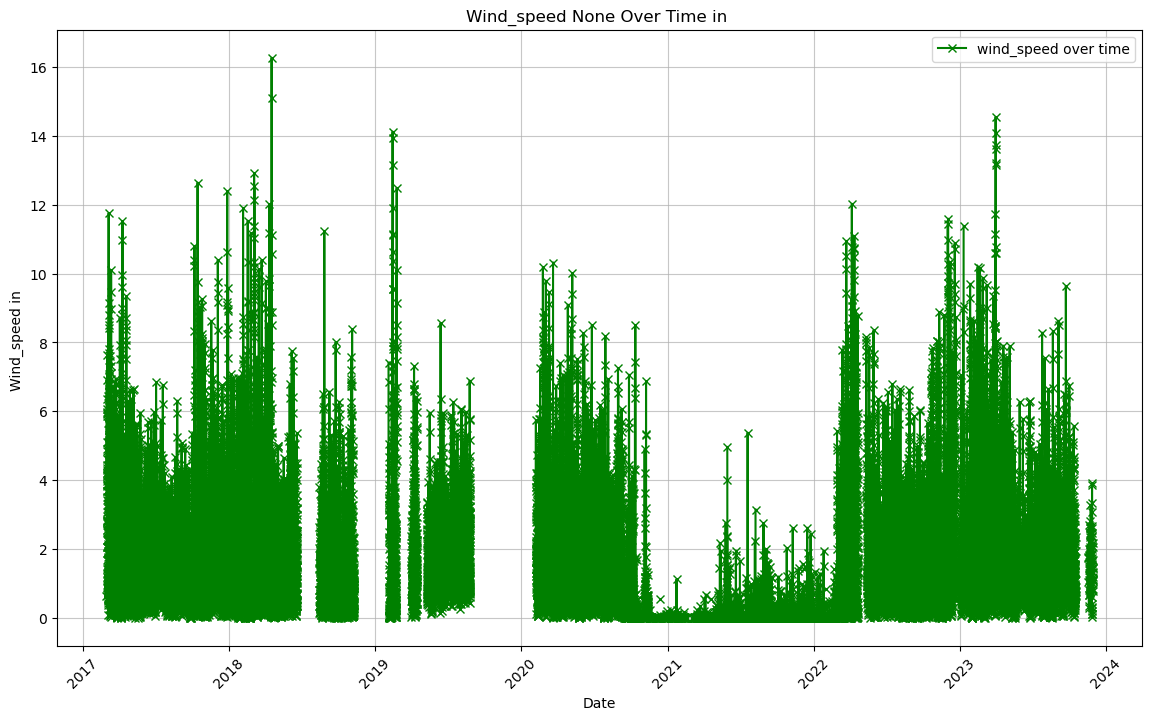

In [51]:
plot_variable_over_time(marshall_hourly_df, "wind_speed", year=None)


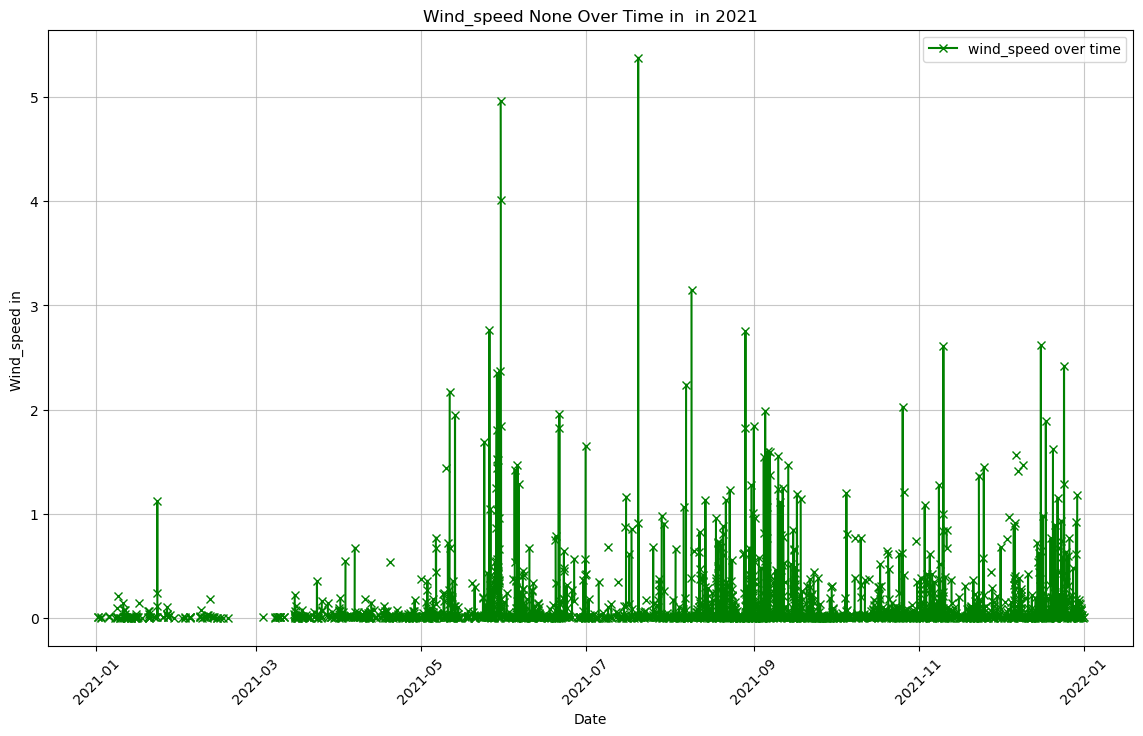

In [52]:
plot_variable_over_time(marshall_hourly_df, "wind_speed", year=2021)


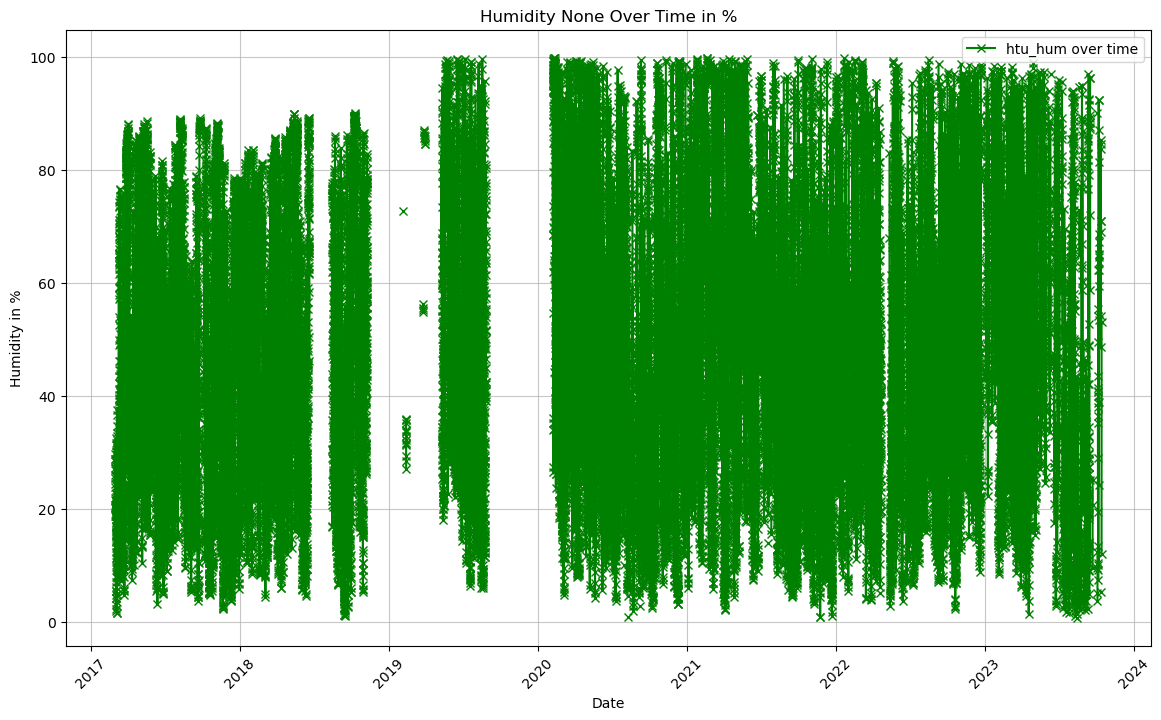

In [53]:
plot_variable_over_time(marshall_hourly_df, "htu_hum", year=None)


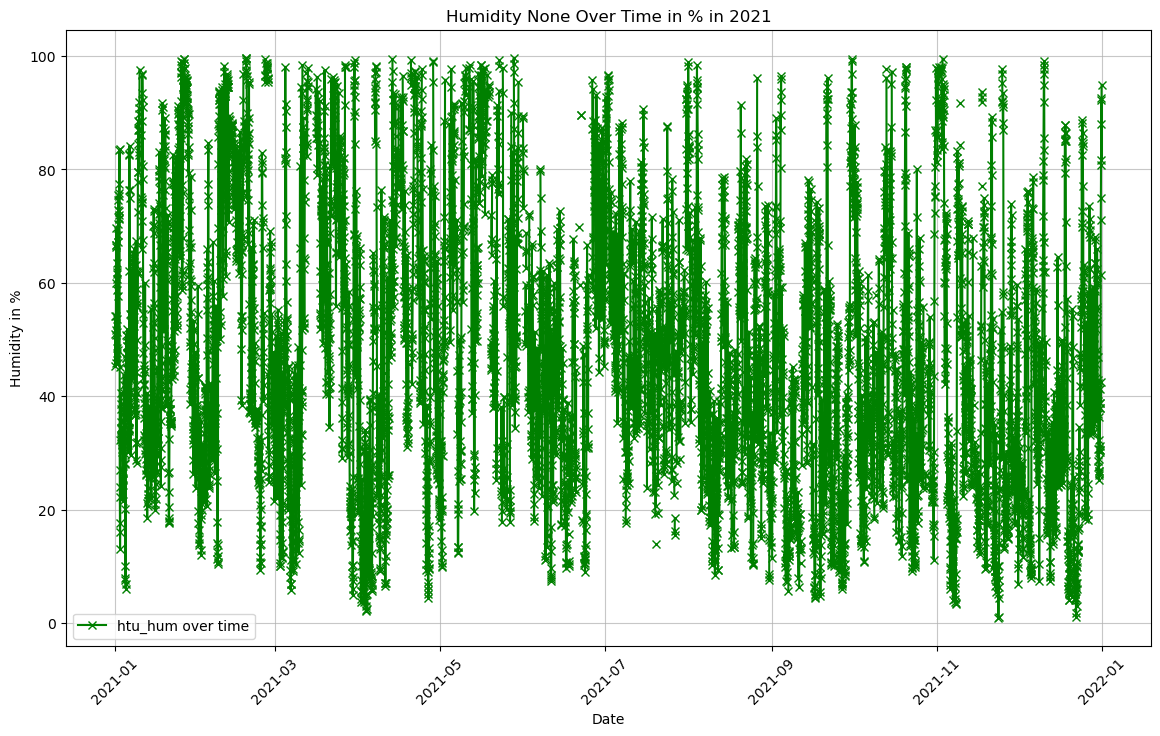

In [54]:
plot_variable_over_time(marshall_hourly_df, "htu_hum", year=2021)


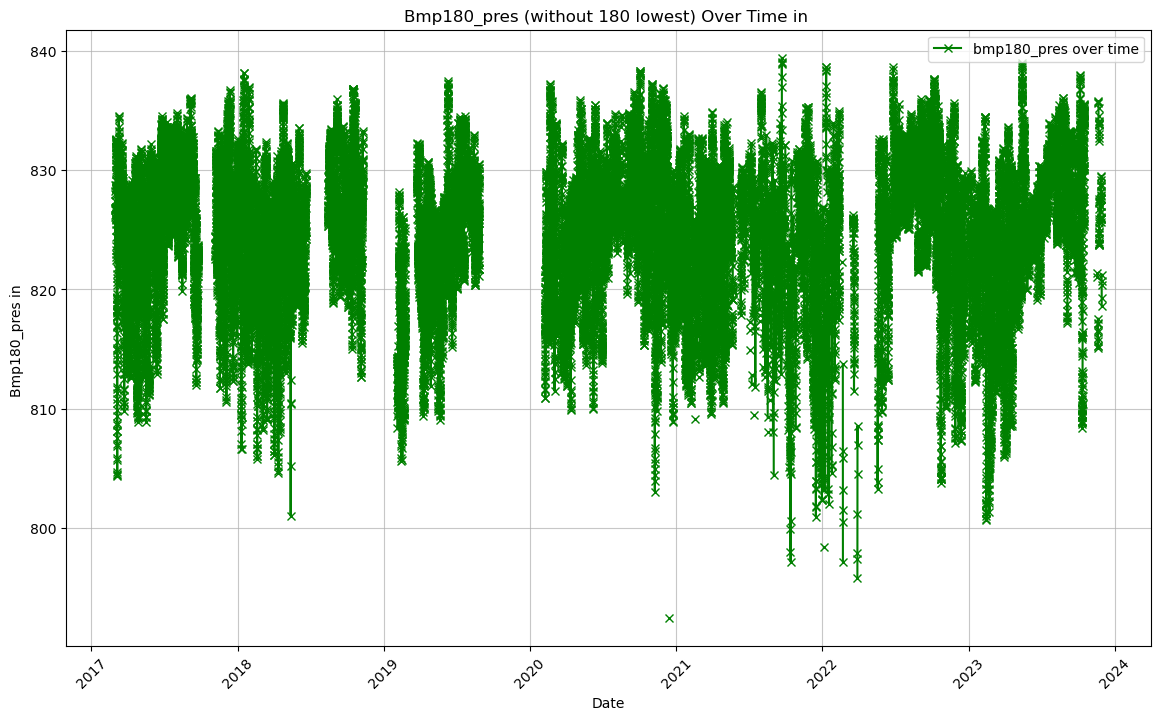

In [58]:

x = 180  # Number of rows to drop

# Sort by the column in descending order and drop the top x rows
top_values = marshall_hourly_df["bmp180_pres"].nsmallest(x).values
df_filtered = marshall_hourly_df[~marshall_hourly_df["bmp180_pres"].isin(top_values)]

plot_variable_over_time(df_filtered, "bmp180_pres", year=None, title_add_on="(without 180 lowest)")

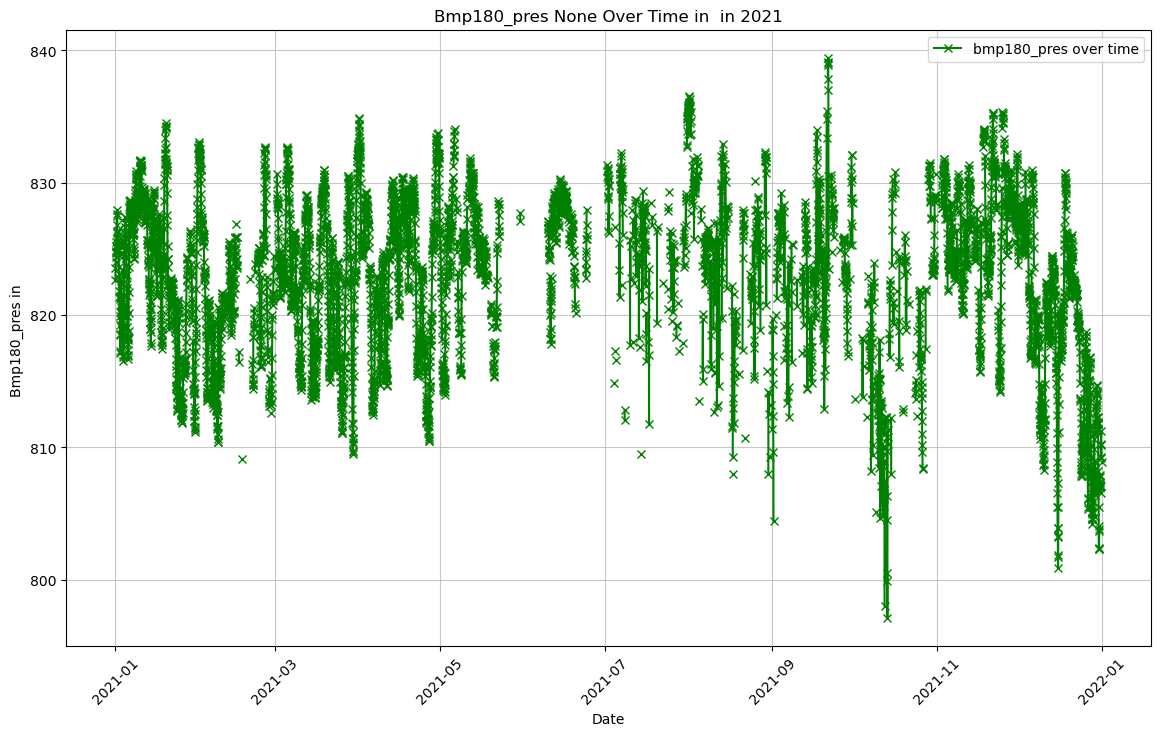

In [59]:
plot_variable_over_time(df_filtered, "bmp180_pres", year=2021)

# Events

In [60]:
era5_marsahll_ds = xr.open_dataset("converted_era5_data/era5_marshall_events.nc")


In [62]:
print("Highest precip. value in ERA5:",era5_marsahll_ds.tp.values.max())
print("Highest temp. value in ERA5:",era5_marsahll_ds.t2m.values.max())
print("Highest wind speed value in ERA5:",era5_marsahll_ds.wind_speed.values.max())

Highest precip. value in ERA5: 14.425681
Highest temp. value in ERA5: 38.97696
Highest wind speed value in ERA5: 18.766888


## Precipitation

In [64]:
# 5 heaviest precipitation events
marshall_hourly_df.sort_values(by=['tipping'], ascending=False)


bmp180_temp  bmp180_pres  bmp180_slp  htu_temp  htu_hum  \
datetime                                                                       
2020-02-08 16:00:00        -1.05      815.910    1011.030     -1.00    73.50   
2020-02-08 17:00:00         1.15      815.400    1008.590      1.15    68.40   
2021-02-19 17:00:00          NaN          NaN         NaN      2.25    40.65   
2020-04-03 19:00:00         0.70      824.600    1020.465      1.10    70.70   
2018-04-13 16:00:00         4.40      814.985    1005.685      5.00    43.00   
...                          ...          ...         ...       ...      ...   
2023-11-29 10:00:00          NaN          NaN         NaN       NaN      NaN   
2023-11-29 11:00:00          NaN          NaN         NaN       NaN      NaN   
2023-11-29 12:00:00          NaN          NaN         NaN       NaN      NaN   
2023-11-29 13:00:00          NaN          NaN         NaN       NaN      NaN   
2023-11-29 14:00:00          NaN          NaN         NaN       NaN      NaN   

                     mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                               
2020-02-08 16:00:00     -0.4    468.0      549.5    3265.5     157.0   
2020-02-08 17:00:00      1.9    105.8      665.5    4472.5     219.0   
2021-02-19 17:00:00      2.6     60.2        NaN       NaN       NaN   
2020-04-03 19:00:00      1.0     60.2        NaN       NaN       NaN   
2018-04-13 16:00:00      5.1     37.6        NaN       NaN       NaN   
...                      ...      ...        ...       ...       ...   
2023-11-29 10:00:00      NaN      NaN        NaN       NaN       NaN   
2023-11-29 11:00:00      NaN      NaN        NaN       NaN       NaN   
2023-11-29 12:00:00      NaN      NaN        NaN       NaN       NaN   
2023-11-29 13:00:00      NaN      NaN        NaN       NaN       NaN   
2023-11-29 14:00:00      NaN      NaN        NaN       NaN       NaN   

                       wind_dir  wind_speed  
datetime                                     
2020-02-08 16:00:00  138.968769    1.910175  
2020-02-08 17:00:00    1.411853    1.381053  
2021-02-19 17:00:00  271.946125         NaN  
2020-04-03 19:00:00   48.420521    1.811053  
2018-04-13 16:00:00         NaN    1.296552  
...                         ...         ...  
2023-11-29 10:00:00         NaN         NaN  
2023-11-29 11:00:00         NaN         NaN  
2023-11-29 12:00:00         NaN         NaN  
2023-11-29 13:00:00         NaN         NaN  
2023-11-29 14:00:00         NaN         NaN  

[59151 rows x 12 columns]

In [65]:
print(marshall_hourly_df.sort_values(by=['tipping'], ascending=False).index[0:5])


DatetimeIndex(['2020-02-08 16:00:00', '2020-02-08 17:00:00',
               '2021-02-19 17:00:00', '2020-04-03 19:00:00',
               '2018-04-13 16:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)


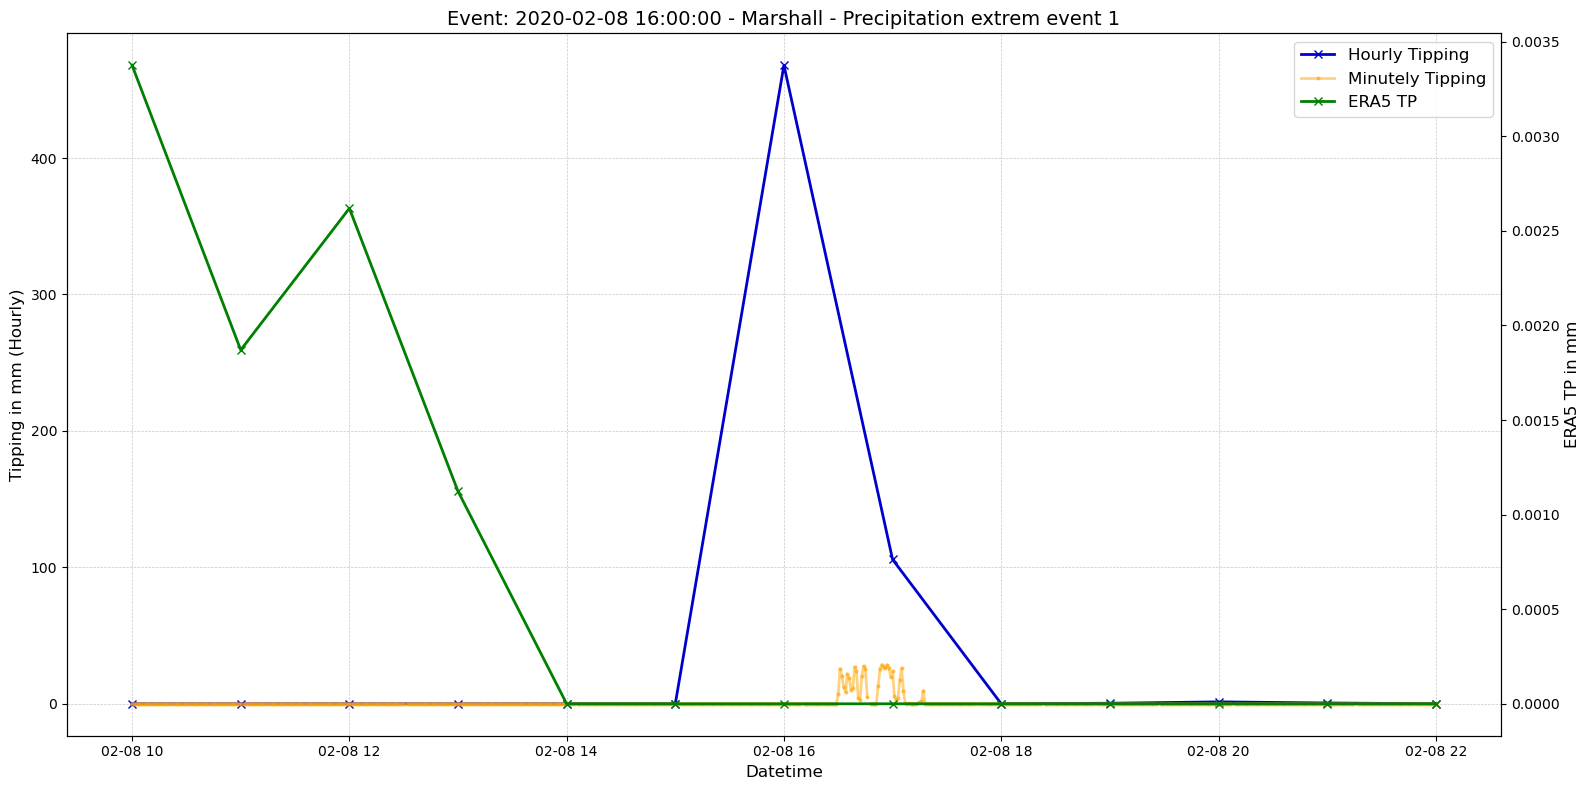

In [81]:
# Example Event 1
event_1 = pd.Timestamp(marshall_hourly_df.sort_values(by=['tipping'], ascending=False).index[0])

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_marsahll_ds,
    same_y_axis= False,
    title_suffix="Marshall - Precipitation extrem event 1",
    save_fig=False
)





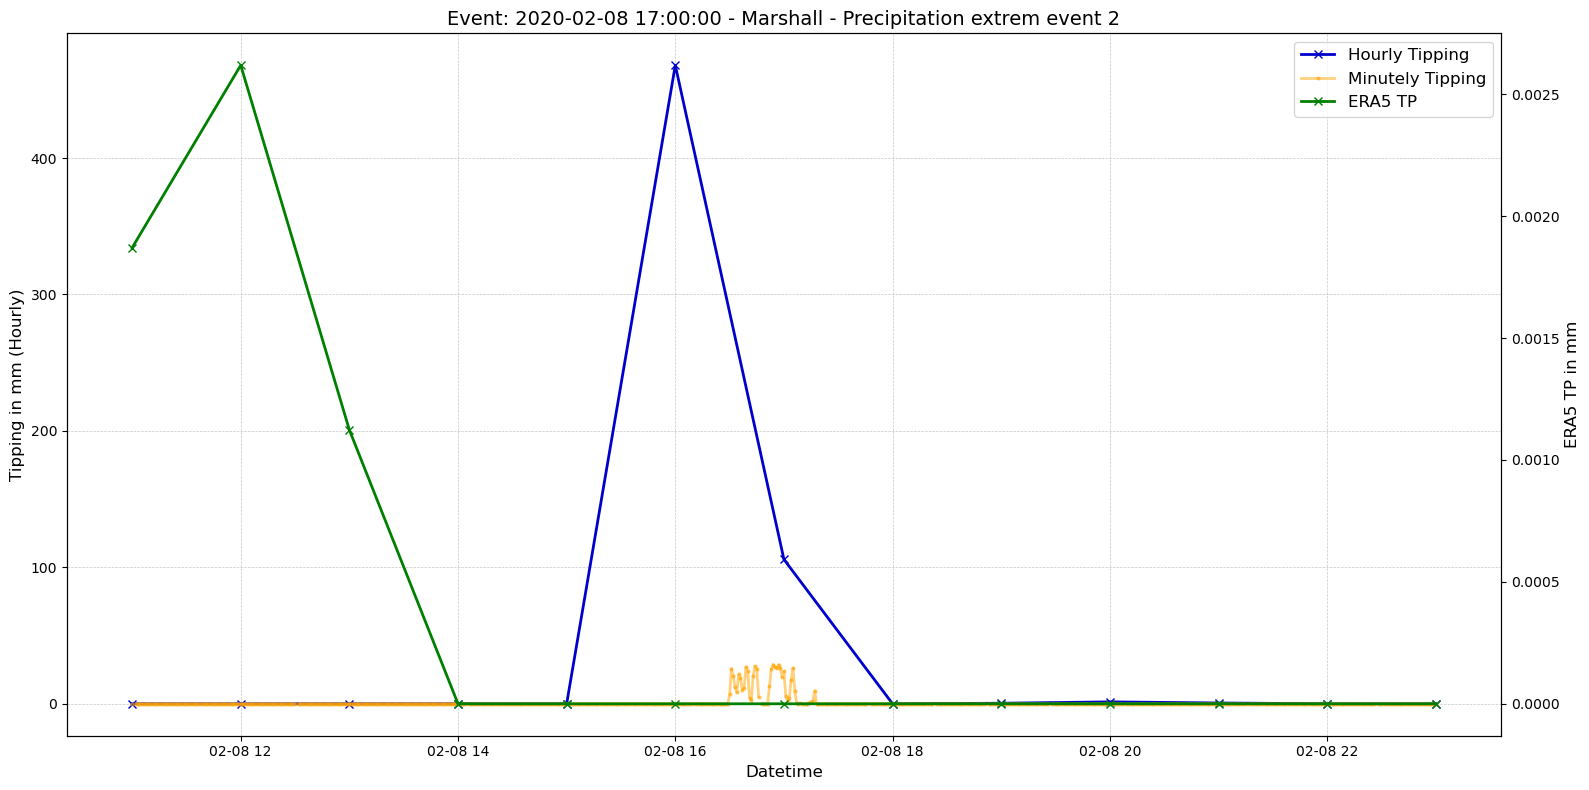

In [82]:
# Example Event 2
event_2 = pd.Timestamp(marshall_hourly_df.sort_values(by=['tipping'], ascending=False).index[1])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_marsahll_ds,
    same_y_axis= False,
    title_suffix="Marshall - Precipitation extrem event 2",
    save_fig=False
)



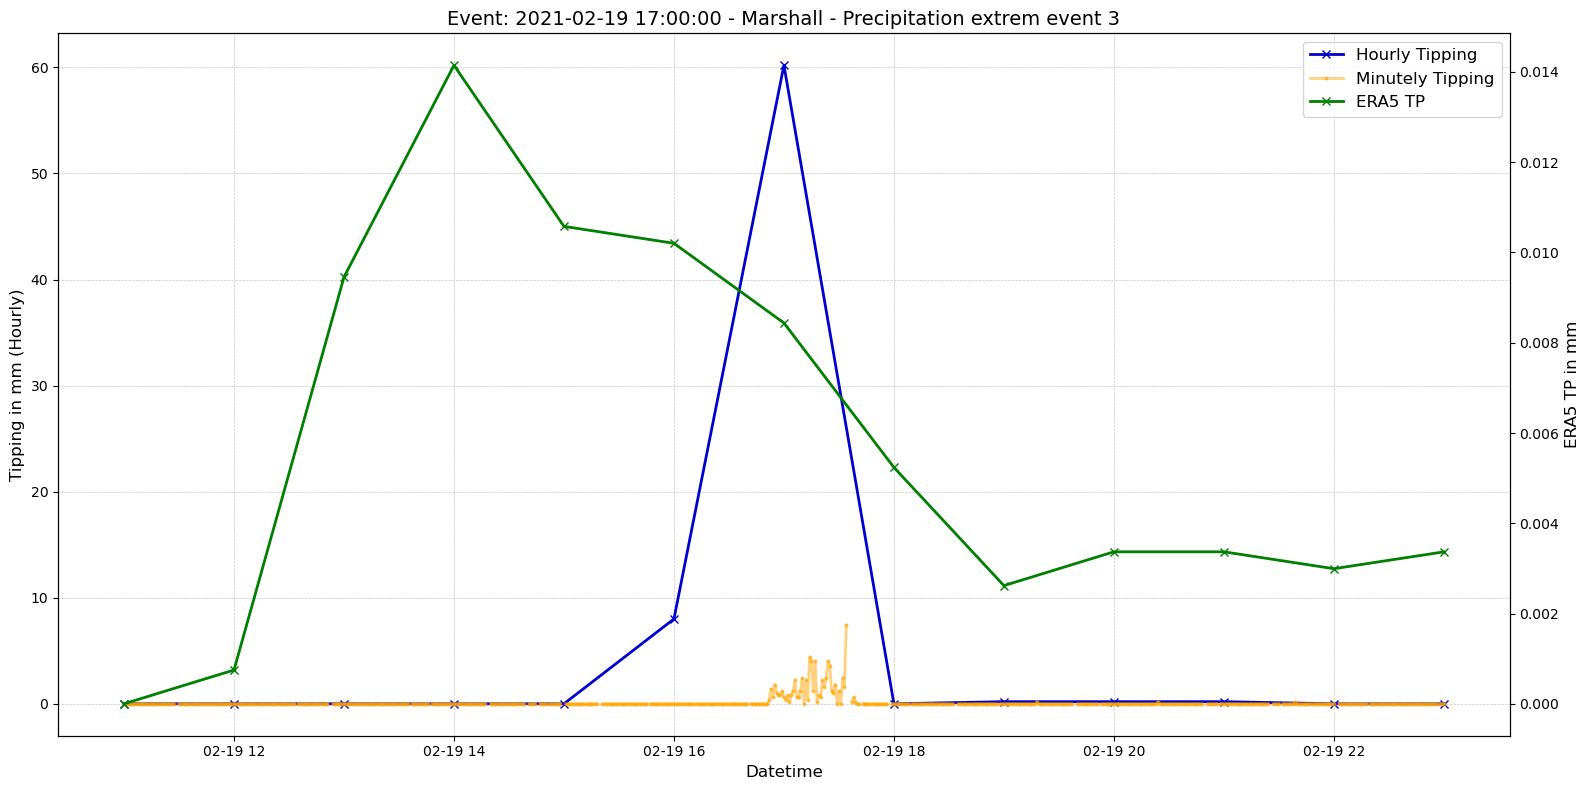

In [83]:
# Example Event 3
event_3 = pd.Timestamp(marshall_hourly_df.sort_values(by=['tipping'], ascending=False).index[2])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_marsahll_ds,
    same_y_axis= False,
    title_suffix="Marshall - Precipitation extrem event 3",
    save_fig=False
)



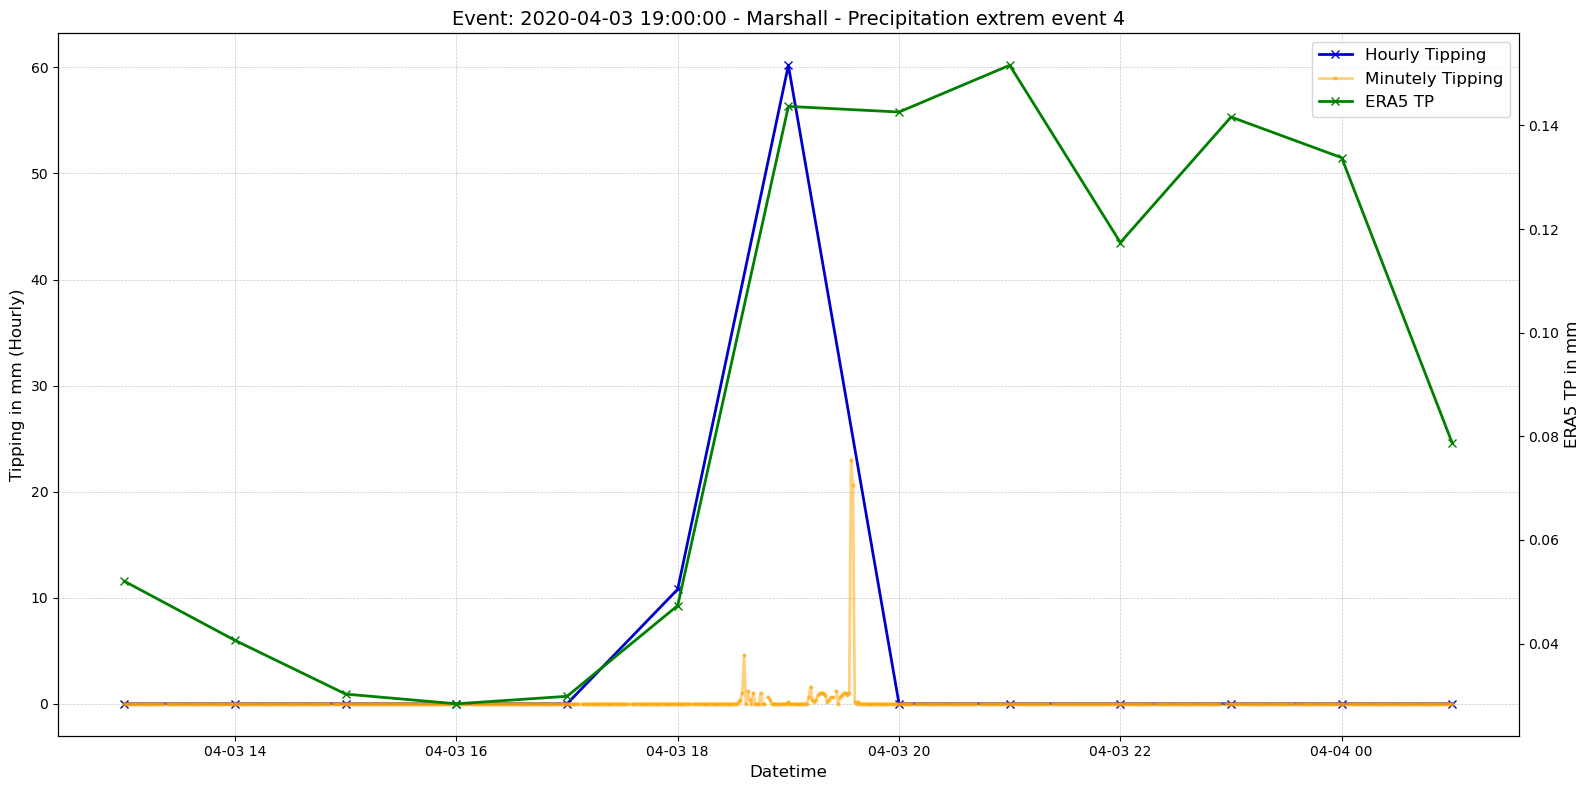

In [84]:
# Example Event 4
event_4 = pd.Timestamp(marshall_hourly_df.sort_values(by=['tipping'], ascending=False).index[3])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_4,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_marsahll_ds,
    same_y_axis= False,
    title_suffix="Marshall - Precipitation extrem event 4",
    save_fig=False
)


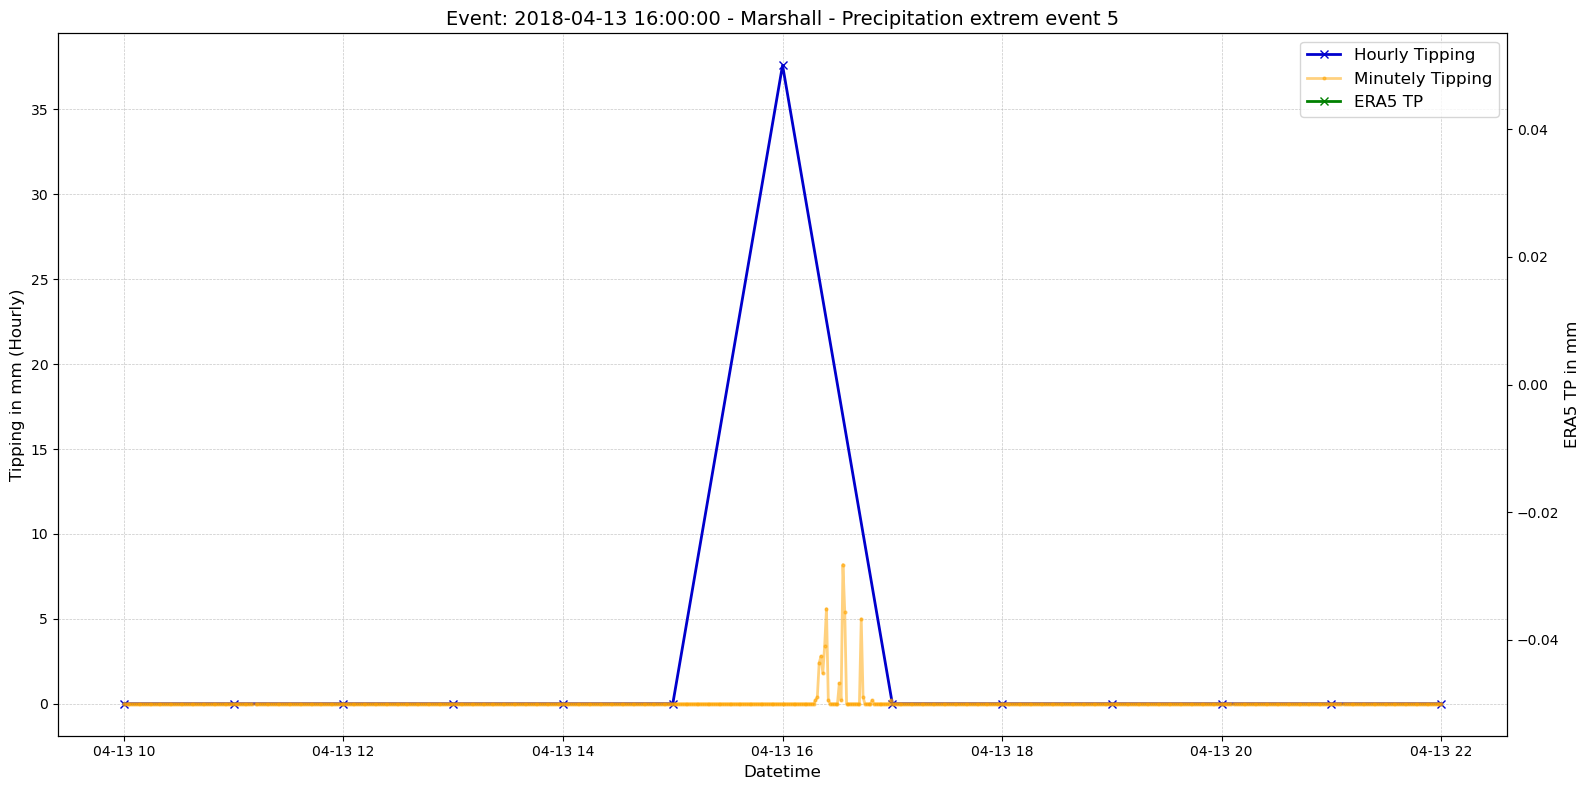

In [85]:
# Example Event 5
event_5 = pd.Timestamp(marshall_hourly_df.sort_values(by=['tipping'], ascending=False).index[4])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_5,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_marsahll_ds,
    same_y_axis= False,
    title_suffix="Marshall - Precipitation extrem event 5",
    save_fig=False
)


## Wind speed

In [71]:
# 5 heaviest precipitation events
marshall_hourly_df.sort_values(by=['wind_speed'], ascending=False)


bmp180_temp  bmp180_pres  bmp180_slp  htu_temp  htu_hum  \
datetime                                                                       
2018-04-17 20:00:00         8.65      812.105     999.040      8.90    22.50   
2018-04-17 21:00:00         8.55      813.075    1000.480      8.85    22.70   
2023-03-31 21:00:00         7.20      812.670    1000.875      7.55    29.60   
2019-02-14 03:00:00         7.90      805.830     991.895       NaN      NaN   
2023-03-31 20:00:00         6.55      812.190    1000.755      6.70    31.35   
...                          ...          ...         ...       ...      ...   
2023-11-29 10:00:00          NaN          NaN         NaN       NaN      NaN   
2023-11-29 11:00:00          NaN          NaN         NaN       NaN      NaN   
2023-11-29 12:00:00          NaN          NaN         NaN       NaN      NaN   
2023-11-29 13:00:00          NaN          NaN         NaN       NaN      NaN   
2023-11-29 14:00:00          NaN          NaN         NaN       NaN      NaN   

                     mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                               
2018-04-17 20:00:00     9.15     22.8        NaN       NaN       NaN   
2018-04-17 21:00:00     9.20     11.4        NaN       NaN       NaN   
2023-03-31 21:00:00     7.55      1.0      676.5    5038.0     224.5   
2019-02-14 03:00:00     8.20      2.8        NaN       NaN       NaN   
2023-03-31 20:00:00     6.85      1.2      622.0    4345.0     195.5   
...                      ...      ...        ...       ...       ...   
2023-11-29 10:00:00      NaN      NaN        NaN       NaN       NaN   
2023-11-29 11:00:00      NaN      NaN        NaN       NaN       NaN   
2023-11-29 12:00:00      NaN      NaN        NaN       NaN       NaN   
2023-11-29 13:00:00      NaN      NaN        NaN       NaN       NaN   
2023-11-29 14:00:00      NaN      NaN        NaN       NaN       NaN   

                       wind_dir  wind_speed  
datetime                                     
2018-04-17 20:00:00         NaN   16.270877  
2018-04-17 21:00:00         NaN   15.102807  
2023-03-31 21:00:00  234.683519   14.553571  
2019-02-14 03:00:00  240.932577   14.124237  
2023-03-31 20:00:00  232.859924   14.095965  
...                         ...         ...  
2023-11-29 10:00:00         NaN         NaN  
2023-11-29 11:00:00         NaN         NaN  
2023-11-29 12:00:00         NaN         NaN  
2023-11-29 13:00:00         NaN         NaN  
2023-11-29 14:00:00         NaN         NaN  

[59151 rows x 12 columns]

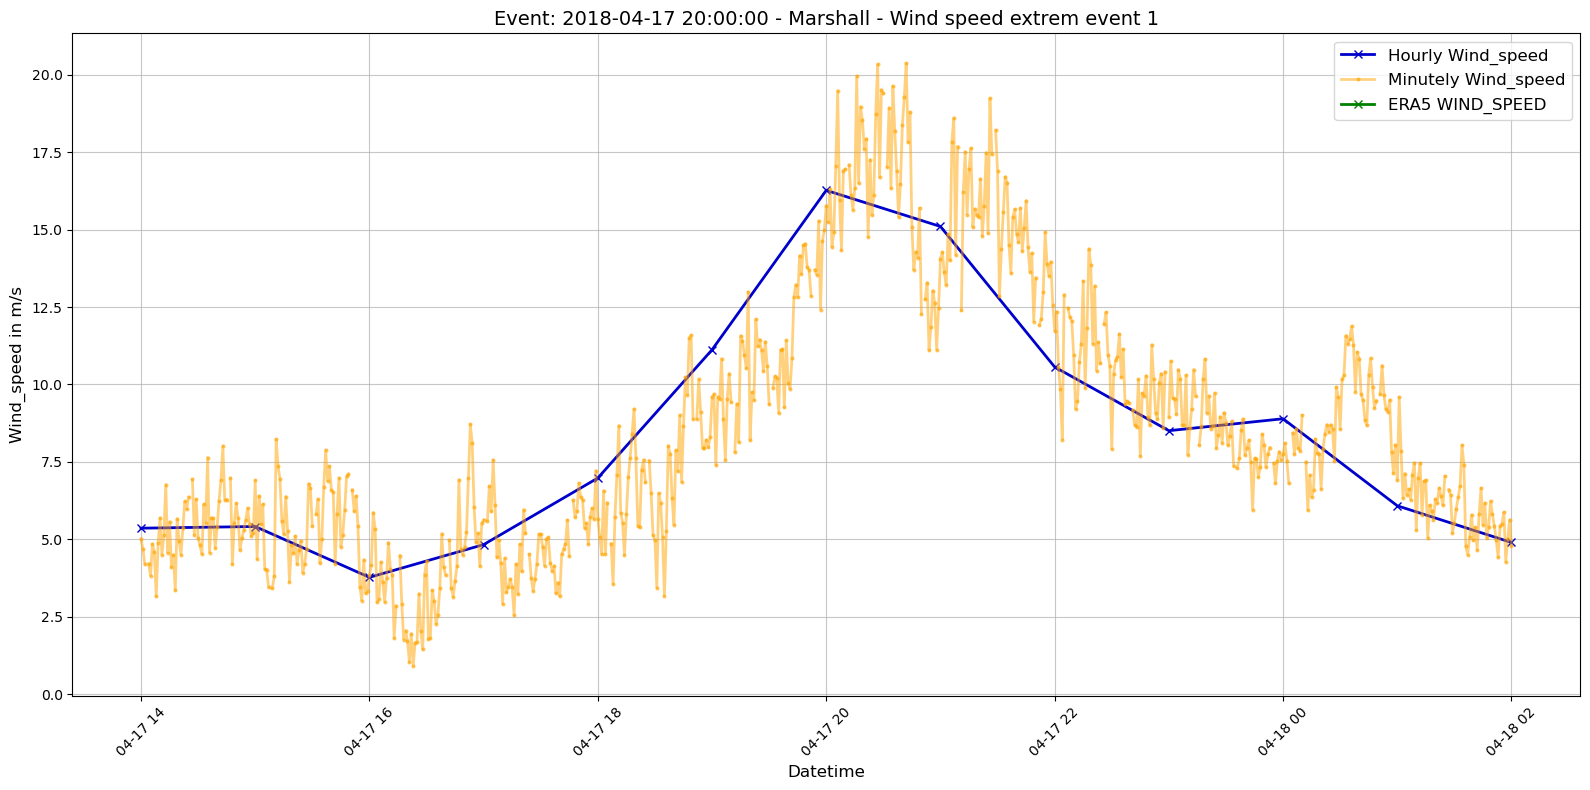

In [86]:
# Example Event 1
event_1 = pd.Timestamp(marshall_hourly_df.sort_values(by=['wind_speed'], ascending=False).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="wind_speed",       # Hourly temperature
    variable_minute="wind_speed",       # Minutely temperature
    era5_variable="wind_speed",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_marsahll_ds,
    same_y_axis= True,
    title_suffix="Marshall - Wind speed extrem event 1",
    save_fig=False
)

## Temperature

In [74]:
# 5 heaviest precipitation events
marshall_hourly_df.sort_values(by=['mcp9808'], ascending=False).head()


bmp180_temp  bmp180_pres  bmp180_slp  htu_temp  htu_hum  \
datetime                                                                       
2022-07-18 19:00:00         35.8      827.105     999.520      35.6    12.75   
2022-07-09 22:00:00         35.6      831.430    1004.730      35.9     6.90   
2022-07-18 18:00:00         35.7      827.460    1000.070      35.4    14.80   
2020-09-05 22:00:00         35.2      829.690    1003.020      35.8     5.40   
2019-07-19 21:00:00         35.2      821.460     992.975      35.7     7.60   

                     mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                               
2022-07-18 19:00:00     35.8      0.0      991.5    7815.5     393.5   
2022-07-09 22:00:00     35.6      0.0      707.5    4917.5     241.5   
2022-07-18 18:00:00     35.6      0.0      933.0    7164.0     362.0   
2020-09-05 22:00:00     35.6      0.0        NaN       NaN       NaN   
2019-07-19 21:00:00     35.5      0.0     1035.5    7948.5     417.0   

                       wind_dir  wind_speed  
datetime                                     
2022-07-18 19:00:00         NaN    3.958246  
2022-07-09 22:00:00    0.577728    2.398929  
2022-07-18 18:00:00  343.778879    2.926379  
2020-09-05 22:00:00         NaN    1.849474  
2019-07-19 21:00:00   55.400144    2.630702

In [75]:
# 5 heaviest precipitation events
marshall_hourly_df.sort_values(by=['mcp9808'], ascending=True).head()


bmp180_temp  bmp180_pres  bmp180_slp  htu_temp  htu_hum  \
datetime                                                                       
2022-12-22 14:00:00        -29.3       827.89    1051.180    -28.90    86.70   
2022-12-22 13:00:00        -27.8       827.05    1048.500    -27.15    89.45   
2022-12-22 15:00:00        -27.8       827.90    1049.570    -27.30    85.90   
2023-02-23 13:00:00        -26.5       818.78    1036.715    -25.90      NaN   
2022-12-22 12:00:00        -26.3       826.08    1045.825    -25.70    92.40   

                     mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                               
2022-12-22 14:00:00   -28.80      0.0      270.0     339.5       7.0   
2022-12-22 13:00:00   -26.95      0.0      262.0     252.0       NaN   
2022-12-22 15:00:00   -26.80      0.0      329.0    1062.0      39.0   
2023-02-23 13:00:00   -25.65      0.0      263.0     260.5       3.0   
2022-12-22 12:00:00   -25.60      0.0      262.0     252.0       NaN   

                       wind_dir  wind_speed  
datetime                                     
2022-12-22 14:00:00  153.293221    1.319828  
2022-12-22 13:00:00  110.232904    1.681724  
2022-12-22 15:00:00  137.794076    1.174138  
2023-02-23 13:00:00  176.373585    1.161379  
2022-12-22 12:00:00   75.895530    3.631579

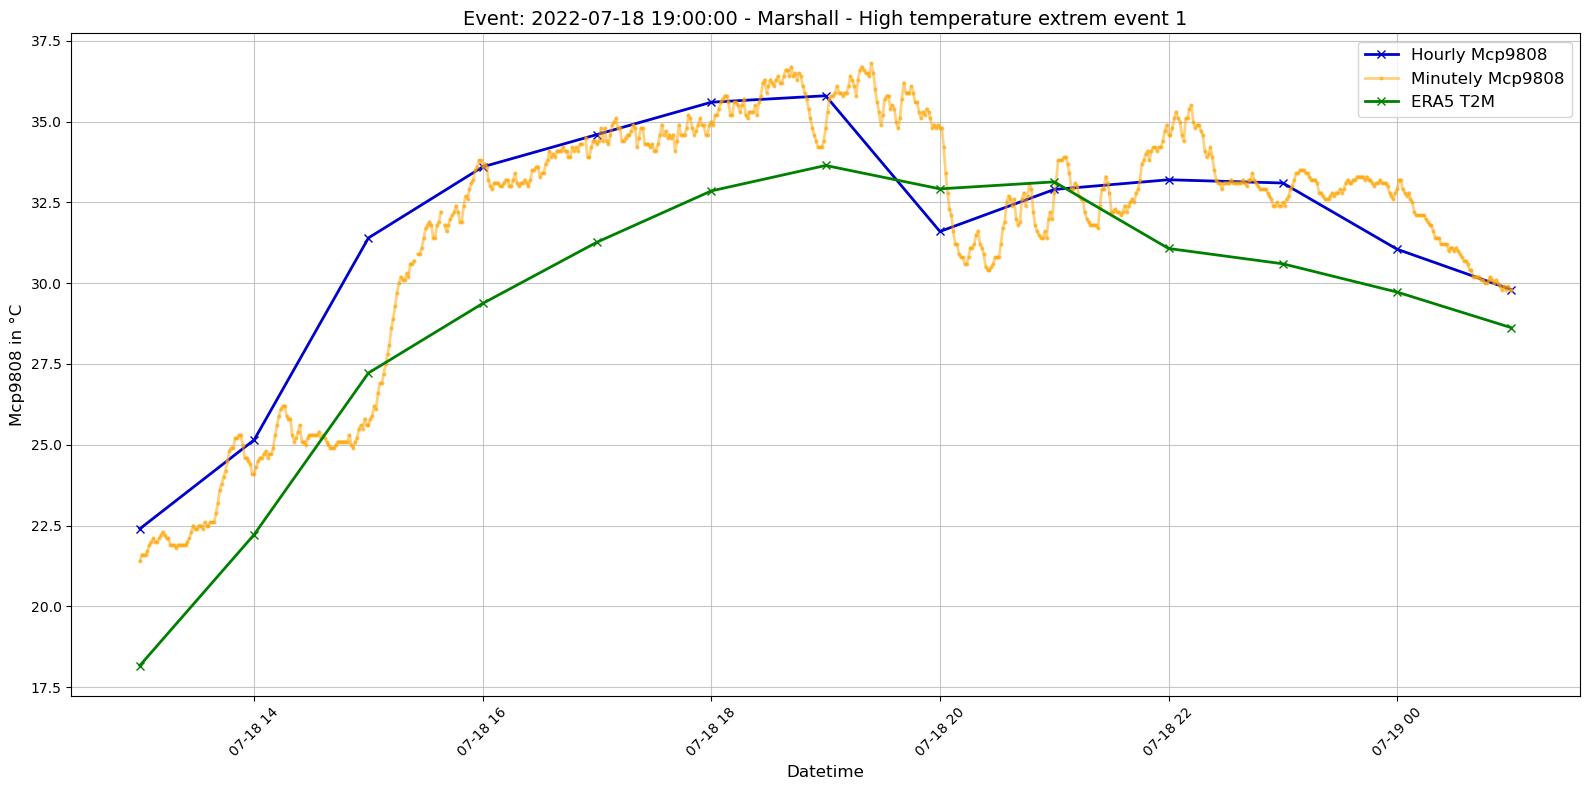

In [87]:
# Example Event 1
event_1 = pd.Timestamp(marshall_hourly_df.sort_values(by=['mcp9808'], ascending=False).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_marsahll_ds,
    same_y_axis= True,
    title_suffix="Marshall - High temperature extrem event 1",
    save_fig=False
)

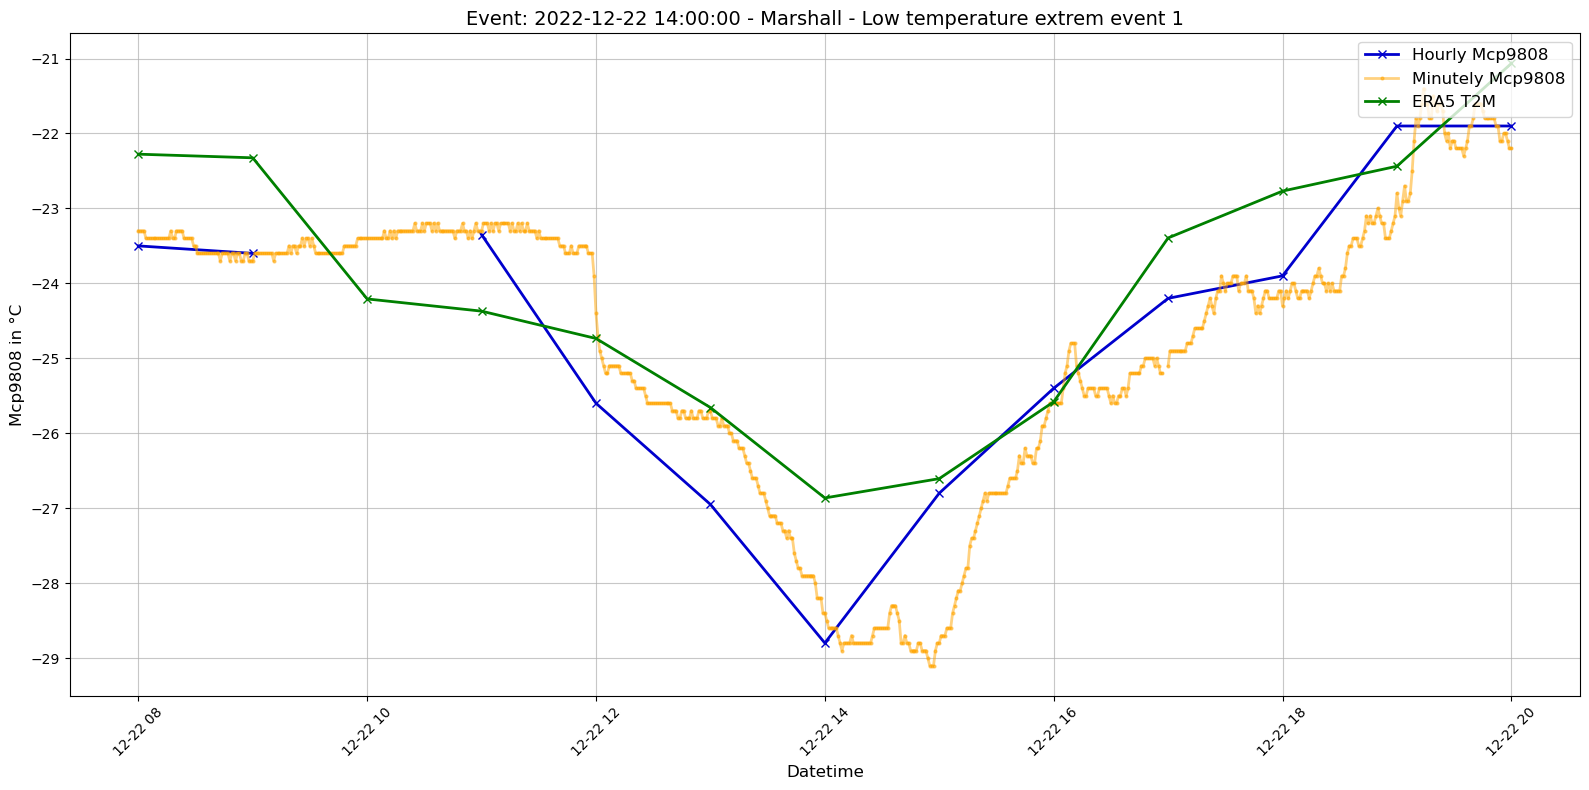

In [88]:
# Example Event 1
event_1 = pd.Timestamp(marshall_hourly_df.sort_values(by=['mcp9808'], ascending=True).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    era5_ds=era5_marsahll_ds,
    same_y_axis= True,
    title_suffix="Marshall - Low temperature extrem event 1",
    save_fig=False
)

## Humidity

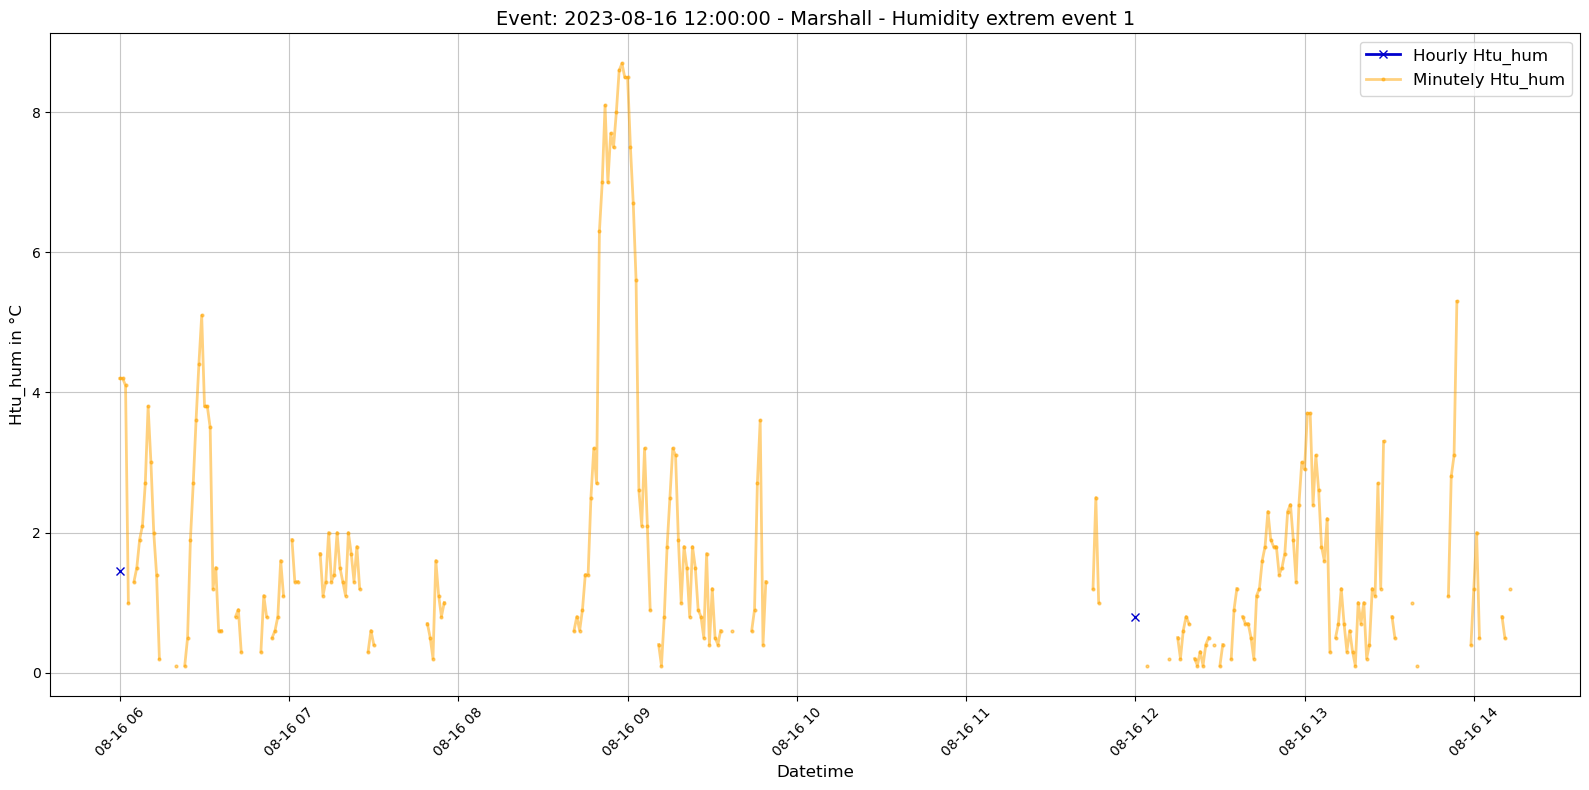

In [89]:
### Example Event 1
event_1 = pd.Timestamp(marshall_hourly_df.sort_values(by=['htu_hum'], ascending=True).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="htu_hum",       # Hourly temperature
    variable_minute="htu_hum",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    same_y_axis= True,
    title_suffix="Marshall - Humidity extrem event 1",
    save_fig=False
)

## Pressure

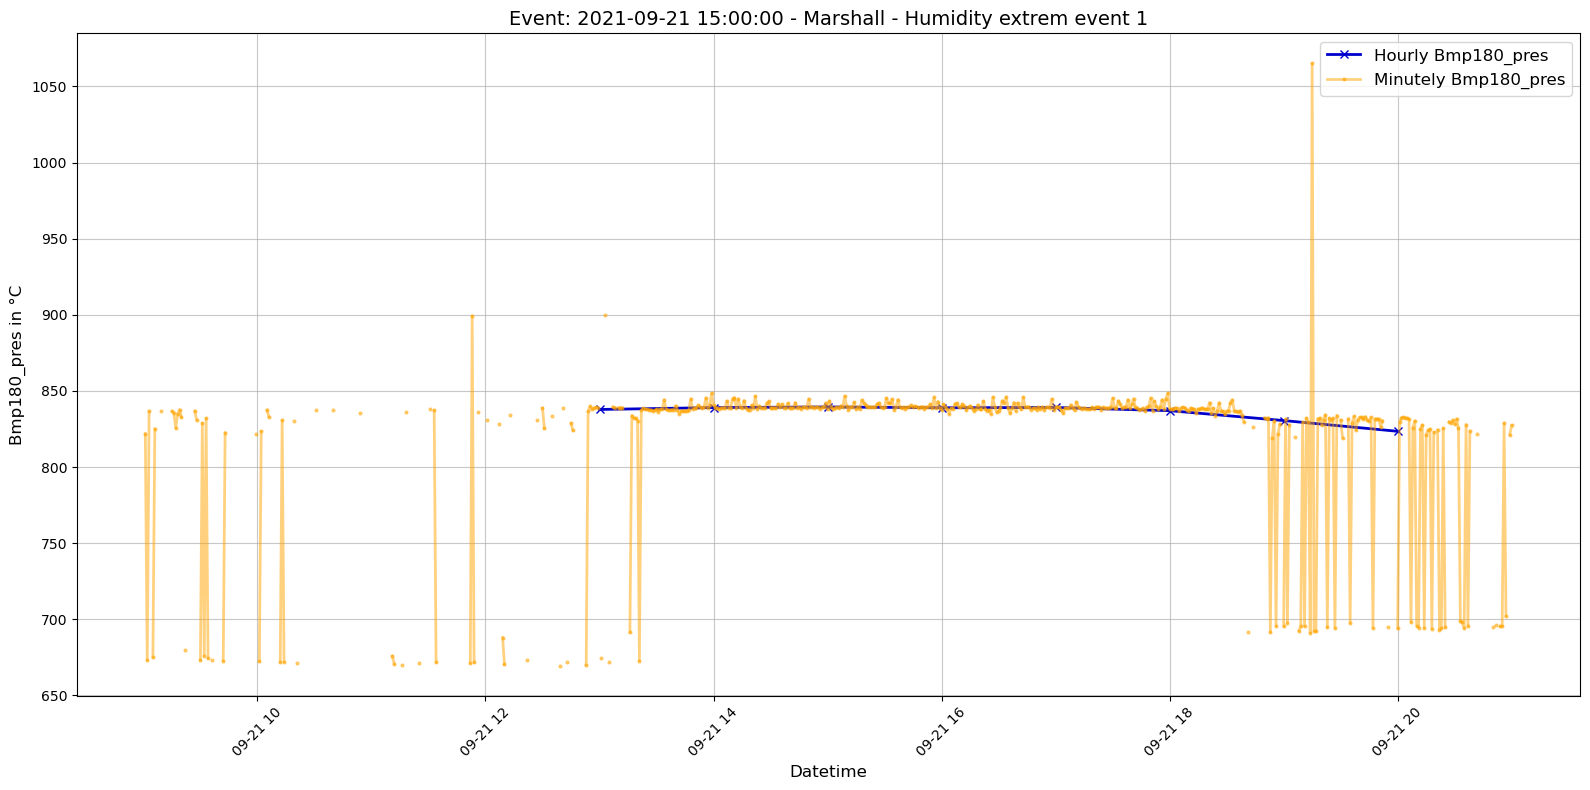

In [90]:
### Example Event 1
event_1 = pd.Timestamp(marshall_hourly_df.sort_values(by=['bmp180_pres'], ascending=False).index[0])


# Plot Event 2: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="bmp180_pres",       # Hourly temperature
    variable_minute="bmp180_pres",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=39.9496,
    lon=-105.196 ,
    time_window=pd.Timedelta(hours=6),
    same_y_axis= True,
    title_suffix="Marshall - Humidity extrem event 1",
    save_fig=False
)

# Comparison to other Datasources

In [90]:
vienna_geopherestation_df.max()

station    5925.0
ff           13.4
rr           39.1
rrm          60.0
rr_flag      10.0
tl           38.5
dtype: float64

In [ ]:
vienna_processed_df = pd.read_csv("station_data_processed/vienna_hourly_processed_data.csv", index_col=0)
vienna_processed_df.index = pd.to_datetime(vienna_processed_df.index, errors='coerce')

# Apply the  aggregation
vienna_hourly_df = apply_aggregation(vienna_processed_df)

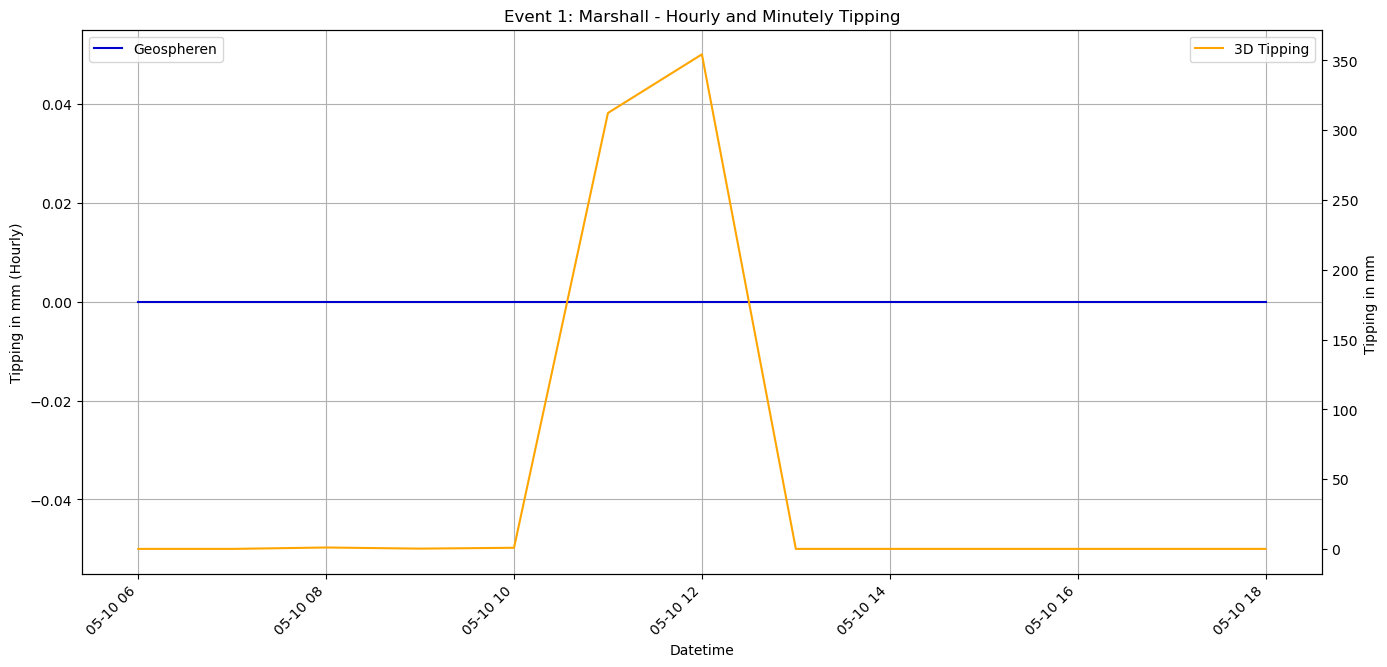

In [92]:
# Create the figure and the first axis

event_1 = pd.Timestamp("2018-05-10 12:00:00")

# measured 468 l/m2 in 1 h and the following hour measured 105 l/m2
# utc in local time 10:00

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_1 - time_delta) & (vienna_geopherestation_df.index <= event_1 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_1 - time_delta) & (vienna_hourly_df.index <= event_1 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 1: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()

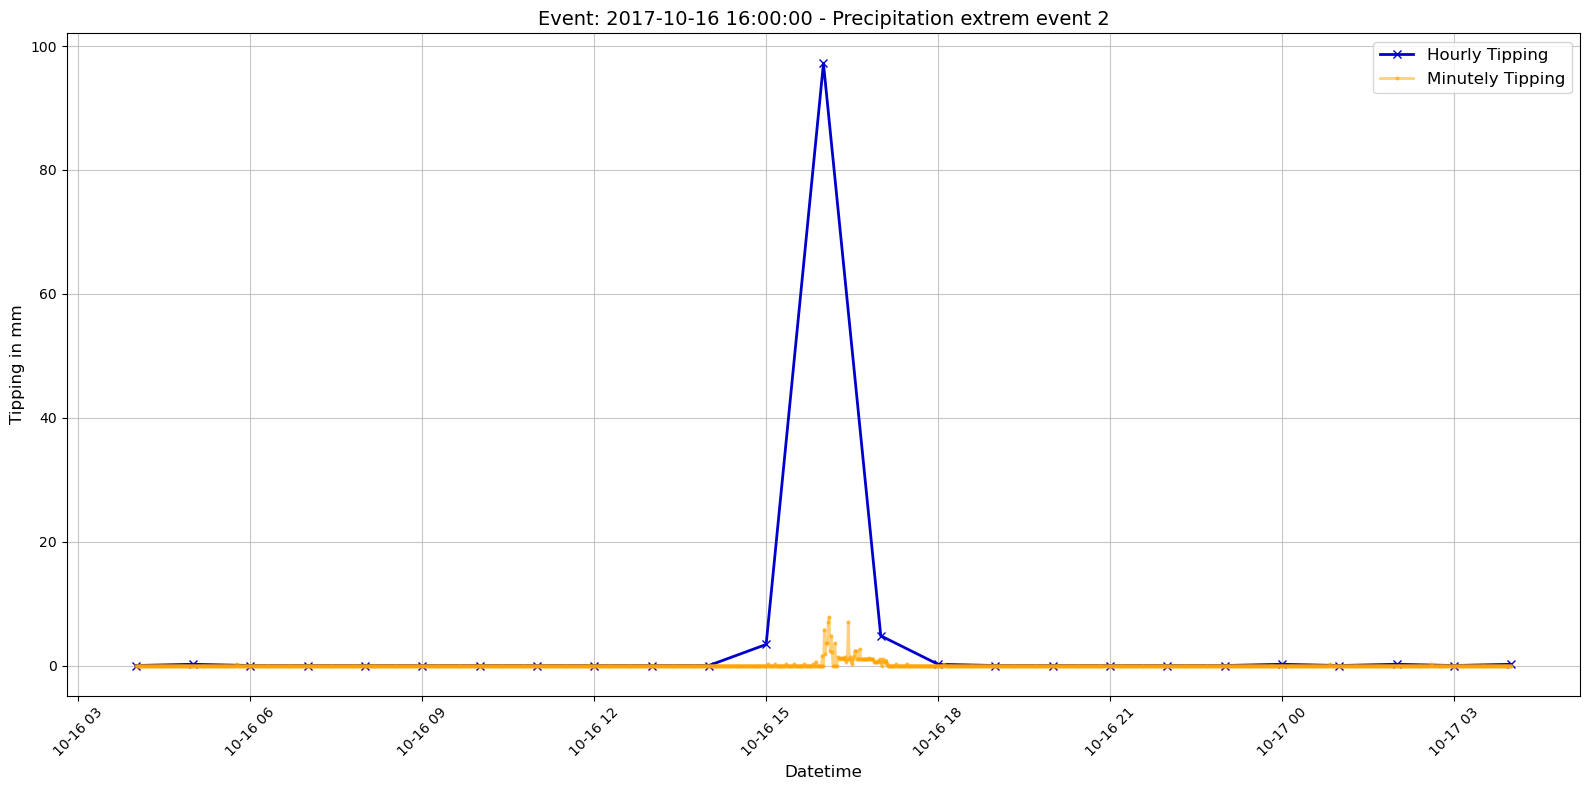

In [93]:
# Example Event 1
event_2 = pd.Timestamp("2017-10-16 16:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_2,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tipping",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation extrem event 2",
    save_fig=False
)

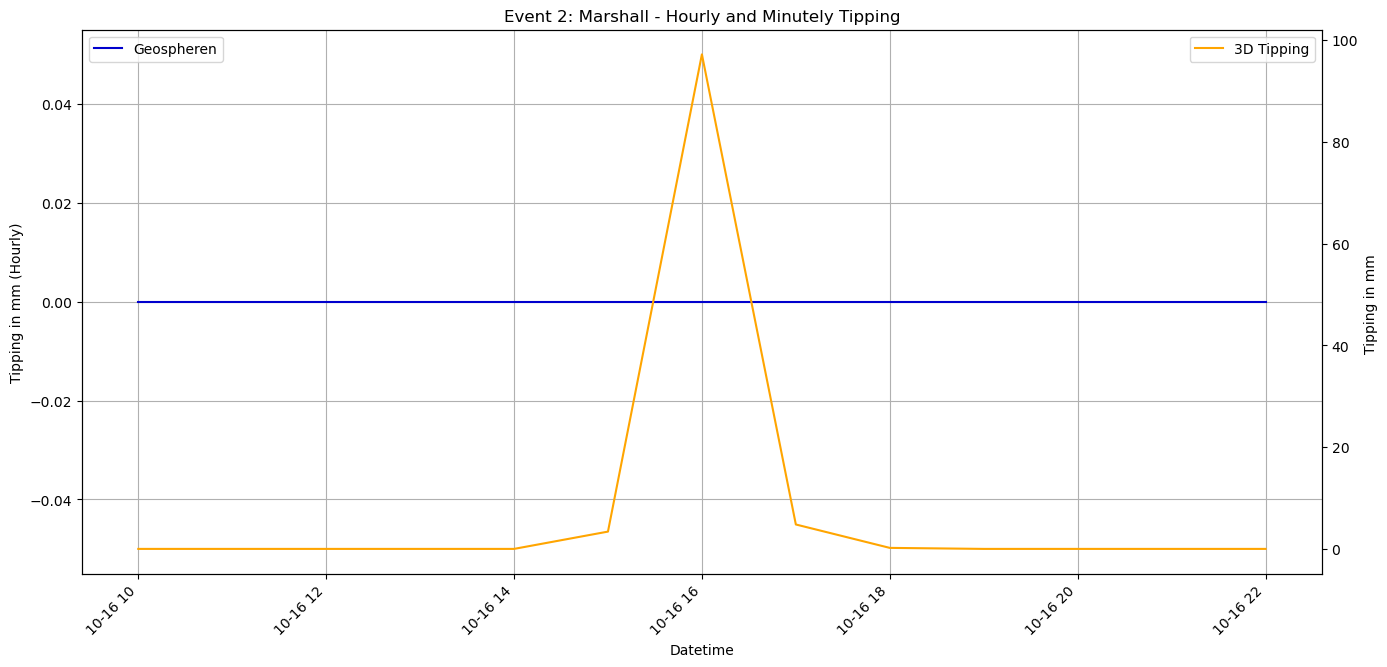

In [96]:
# Create the figure and the first axis
event_2 = pd.Timestamp("2017-10-16 16:00:00")

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_2 - time_delta) & (vienna_geopherestation_df.index <= event_2 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_2 - time_delta) & (vienna_hourly_df.index <= event_2 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 2: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()

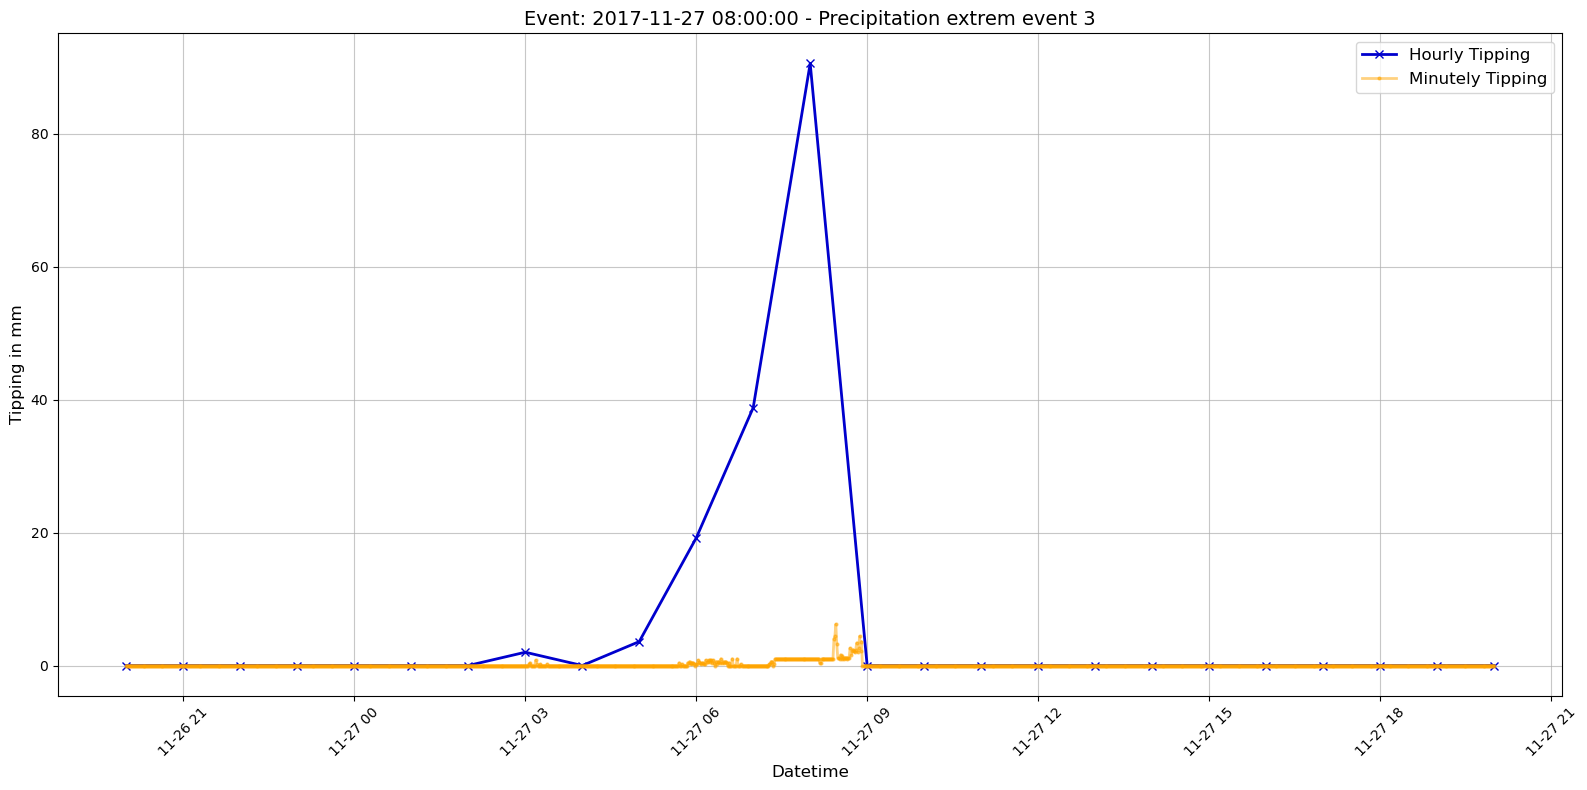

In [97]:
# Example Event 1
event_3 = pd.Timestamp("2017-11-27 08:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tipping",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation extrem event 3",
    save_fig=False
)

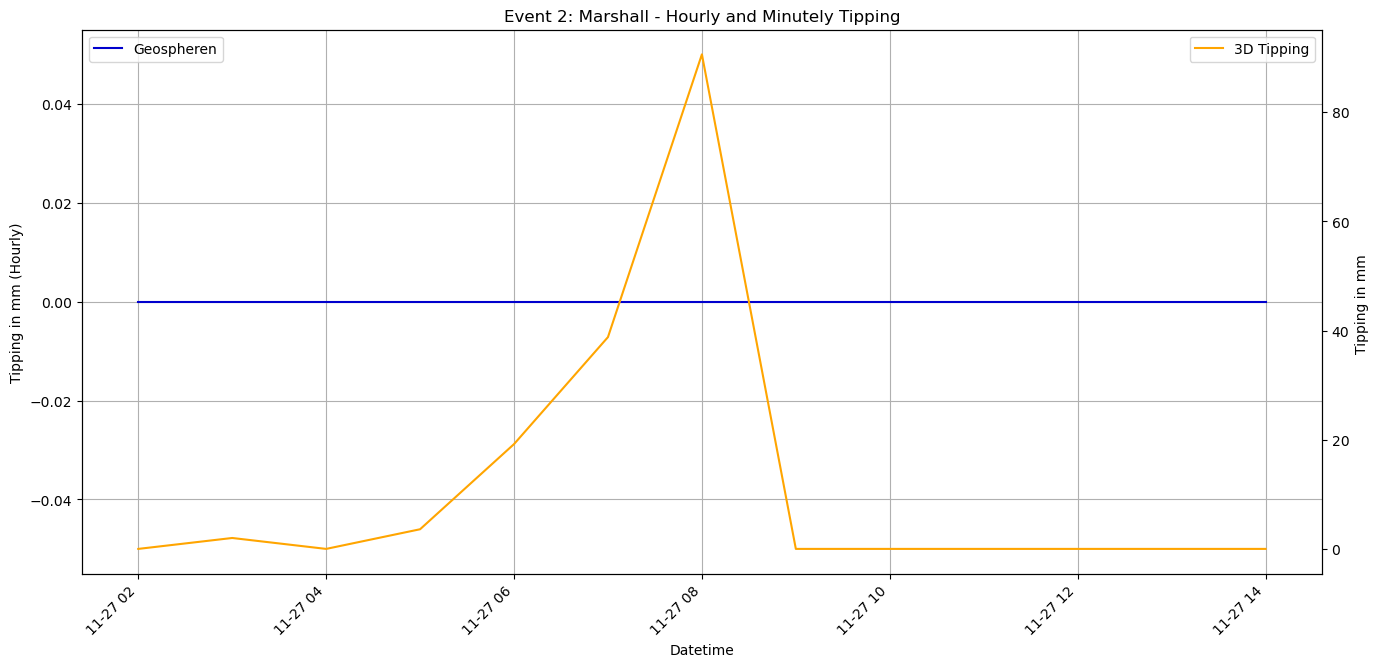

In [98]:
# Create the figure and the first axis

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df_vg = vienna_geopherestation_df[(vienna_geopherestation_df.index >= event_3 - time_delta) & (vienna_geopherestation_df.index <= event_3 + time_delta)]
filtered_df =   vienna_hourly_df[(vienna_hourly_df.index >= event_3 - time_delta) & (vienna_hourly_df.index <= event_3 + time_delta)]

# View the filtered DataFrame
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df_vg["rr"], color='mediumblue', label="Geospheren")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc="upper left")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_df["tipping"], color='orange', label="3D Tipping")
ax2.set_ylabel("Tipping in mm ")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)
plt.legend()

# Set the title
plt.title("Event 2: Marshall - Hourly and Minutely Tipping")

# Show the plot
plt.show()